# <center>Курсовой проект. Версия 1<a class="anchor" id="course_project"></a><center>

**Постановка задачи**<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет


**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Примерное описание этапов выполнения курсового проекта**<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

# Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

# Библиотеки. Функции

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, f1_score, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

In [4]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [5]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)


    return df.sample(frac=1) 

**Пути к директориям и файлам**

In [6]:
TRAIN_DATASET_PATH = './data/course_project_train.csv'
TEST_DATASET_PATH = './data/course_project_test.csv'

**Загрузка данных**

In [7]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [8]:
# разбиение признаков на числовые и категориальные
FEATURES = df_train.columns.to_list()

TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
            'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# получаем категориальные признаки вычитая из всех признаков числовые и целевой признак
CAT_FEATURE_NAMES = [item for item in FEATURES if item not in NUM_FEATURE_NAMES]

CAT_FEATURE_NAMES.remove(TARGET_NAME)

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES #+ NEW_FEATURE_NAMES

# Обзор датасета

In [26]:
df_train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [8]:
df_train.shape

(7500, 17)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [64]:
df_train.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [11]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

In [12]:
df_test.shape

(2500, 16)

Количество уникальных значений

In [13]:
df_train.nunique()

Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

In [14]:
df_test.nunique()

Home Ownership                     4
Annual Income                   1929
Years in current job              11
Tax Liens                          8
Number of Open Accounts           35
Years of Credit History          345
Maximum Open Credit             2435
Number of Credit Problems          8
Months since last delinquent      83
Bankruptcies                       6
Purpose                           14
Term                               2
Current Loan Amount             2026
Current Credit Balance          2385
Monthly Debt                    2416
Credit Score                     211
dtype: int64

## Обзор категориальных переменных

In [12]:
df_train['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [13]:
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [14]:
df_train['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [15]:
df_train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

---

# Baseline

Decision Tree Classifier

Обновляем датасет

In [153]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Заполняем пропуски медианой

In [59]:
df_train = df_train.fillna(df_train.median(axis=0), axis=0)
#df_train = df_train.fillna(df_train.mode()[0:])
df_train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                          32.0           1.0   
1                        0.0                          32.0           0.0   
2                        0.0                          32.0           0.0   
3                        1.0                          32.0           1.0   
4                        1.0                          32.0           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

Переводим категориальные признаки в количественные

In [155]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)
df_train.nunique()

Annual Income                     5478
Tax Liens                            8
Number of Open Accounts             39
Years of Credit History            408
Maximum Open Credit               6963
Number of Credit Problems            8
Months since last delinquent        89
Bankruptcies                         5
Current Loan Amount               5386
Current Credit Balance            6592
Monthly Debt                      6716
Credit Score                       268
Credit Default                       2
Home Ownership_Have Mortgage         2
Home Ownership_Home Mortgage         2
Home Ownership_Own Home              2
Home Ownership_Rent                  2
Years in current job_1 year          2
Years in current job_10+ years       2
Years in current job_2 years         2
Years in current job_3 years         2
Years in current job_4 years         2
Years in current job_5 years         2
Years in current job_6 years         2
Years in current job_7 years         2
Years in current job_8 ye

Формируем выборки

In [156]:
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape

((6000, 44), (1500, 44))

In [21]:
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape

((6000, 44), (1500, 44))

Подбираем гиперпараметры

In [157]:
%%time
tree = DecisionTreeClassifier(random_state=1)

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

Wall time: 17 s


In [158]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 5}

Предсказываем значения трейновой и тестовой выборки

In [159]:
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

Подсчитываем метрики <a class="anchor" id="count_metrics"></a>

In [160]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

Accuracy на трейне 0.7786666666666666
Accuracy на тесте 0.7673333333333333


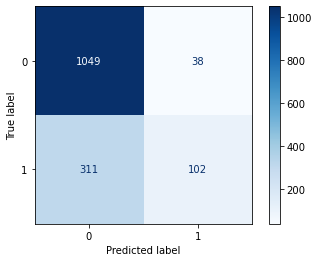

In [161]:
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

Основные метрики из Classification report

In [162]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1087
           1       0.73      0.25      0.37       413

    accuracy                           0.77      1500
   macro avg       0.75      0.61      0.61      1500
weighted avg       0.76      0.77      0.72      1500



In [163]:
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

F1-score = 0.369


Замена NaN на медиану F1 = 0.369


Вероятности предсказания классов.

In [40]:
# predict_proba возвращает вероятность
pred_proba_test = tree.predict_proba(X_test)

# выведем вероятности: 1-й столбец для нулевого клааса, 2-й - для первого класса
pred_proba_test[:5]

array([[0.89193825, 0.10806175],
       [0.76868132, 0.23131868],
       [0.57709251, 0.42290749],
       [0.81759657, 0.18240343],
       [0.76868132, 0.23131868]])

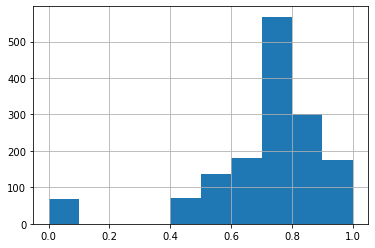

In [42]:
pd.Series(pred_proba_test[:,0]).hist();

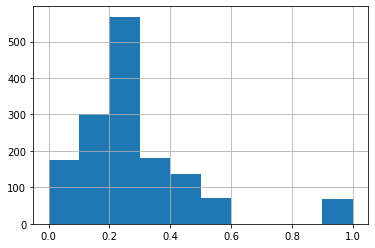

In [41]:
pd.Series(pred_proba_test[:,1]).hist();

Меняем отсечку вручную

In [81]:
pred_test = np.where(pred_proba_test[:,1] >= 0.2, 1, 0)

In [82]:
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

F1-score = 0.498


In [70]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.82      0.71      0.76      1087
           1       0.43      0.59      0.50       413

    accuracy                           0.67      1500
   macro avg       0.62      0.65      0.63      1500
weighted avg       0.71      0.67      0.69      1500



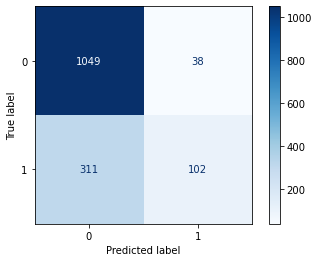

In [83]:
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

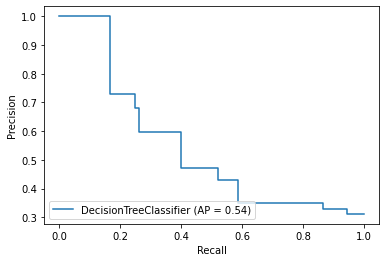

In [86]:
plot_precision_recall_curve(tree, X_test, y_test);

In [87]:
precision_recall_curve(y_test, pred_proba_test[:, 1])

(array([0.31169811, 0.33022862, 0.34926829, 0.43137255, 0.47045952,
        0.59566787, 0.67924528, 0.72857143, 1.        , 1.        ]),
 array([1.        , 0.94430993, 0.86682809, 0.58595642, 0.52058111,
        0.39951574, 0.26150121, 0.24697337, 0.16464891, 0.        ]),
 array([0.10806175, 0.18240343, 0.23131868, 0.27152318, 0.33245383,
        0.42290749, 0.46428571, 0.55780347, 1.        ]))

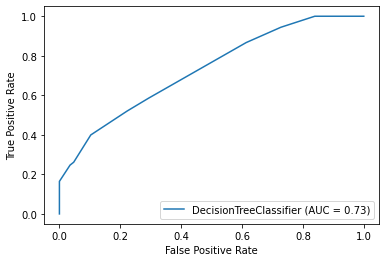

In [88]:
plot_roc_curve(tree, X_test, y_test);

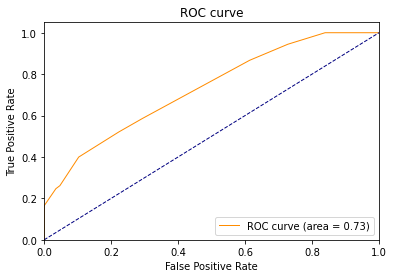

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba_test[:,1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

Ниже пунктирной криваой падать нельзя, потому что ниже начинаются случайные значения.

---

## Baseline с отбором признаков

Обновляем датасет

In [352]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Выделение целевой переменной и групп признаков

In [91]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                           'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                           'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

Корреляция с базовыми признаками

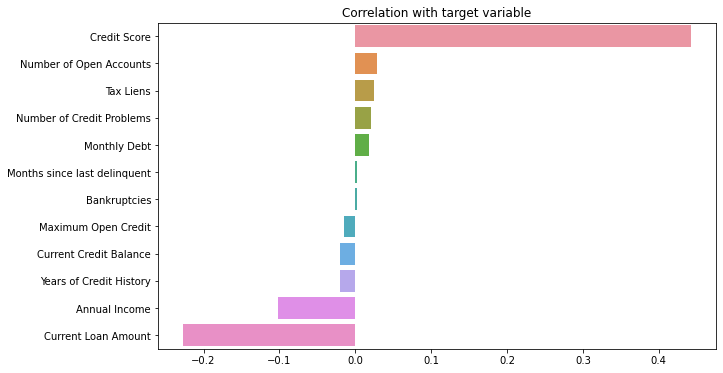

In [354]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Выбираем наиболее значимые признаки** [:кол-во признаков]

In [355]:
features = corr_with_target.sort_values(ascending=False, key=lambda x: abs(x))[:12]
features

Credit Score                    0.442050
Current Loan Amount            -0.226522
Annual Income                  -0.101375
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Years of Credit History        -0.020567
Number of Credit Problems       0.020088
Current Credit Balance         -0.019522
Monthly Debt                    0.018480
Maximum Open Credit            -0.014275
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Name: Credit Default, dtype: float64

Список выбранных признаков

In [356]:
features_names = features.index
features_names

Index(['Credit Score', 'Current Loan Amount', 'Annual Income',
       'Number of Open Accounts', 'Tax Liens', 'Years of Credit History',
       'Number of Credit Problems', 'Current Credit Balance', 'Monthly Debt',
       'Maximum Open Credit', 'Months since last delinquent', 'Bankruptcies'],
      dtype='object')

Оставляем в датасете только выбранные признаки

In [357]:
df_train = df_train[features_names]
df_train.head()

Credit Score  Current Loan Amount  Annual Income  Number of Open Accounts  \
0         749.0           99999999.0       482087.0                     11.0   
1         737.0             264968.0      1025487.0                     15.0   
2         742.0           99999999.0       751412.0                     11.0   
3         694.0             121396.0       805068.0                      8.0   
4         719.0             125840.0       776264.0                     13.0   

   Tax Liens  Years of Credit History  Number of Credit Problems  \
0        0.0                     26.3                        1.0   
1        0.0                     15.3                        0.0   
2        0.0                     35.0                        0.0   
3        0.0                     22.5                        1.0   
4        0.0                     13.6                        1.0   

   Current Credit Balance  Monthly Debt  Maximum Open Credit  \
0                 47386.0        7914.0             685960.0   
1                394972.0       18373.0            1181730.0   
2                308389.0       13651.0            1182434.0   
3                 95855.0       11338.0             147400.0   
4                 93309.0        7180.0             385836.0   

   Months since last delinquent  Bankruptcies  
0                           NaN           1.0  
1                           NaN           0.0  
2                           NaN           0.0  
3                           NaN           1.0  
4                           NaN           0.0

In [358]:
df_test = df_test[features_names]
df_test.head()

Credit Score  Current Loan Amount  Annual Income  Number of Open Accounts  \
0           NaN             162470.0            NaN                      9.0   
1         699.0              78298.0       231838.0                      6.0   
2        7260.0             200178.0      1152540.0                     10.0   
3         739.0             217382.0      1220313.0                     16.0   
4         706.0             777634.0      2340952.0                     11.0   

   Tax Liens  Years of Credit History  Number of Credit Problems  \
0        0.0                     12.5                        0.0   
1        0.0                     32.7                        0.0   
2        0.0                     13.7                        0.0   
3        0.0                     17.0                        0.0   
4        0.0                     23.6                        0.0   

   Current Credit Balance  Monthly Debt  Maximum Open Credit  \
0                105906.0        6813.0             220968.0   
1                 46037.0        2318.0              55946.0   
2                146490.0       18729.0             204600.0   
3                213199.0       27559.0             456302.0   
4                425391.0       42605.0            1207272.0   

   Months since last delinquent  Bankruptcies  
0                          70.0           0.0  
1                           8.0           0.0  
2                           NaN           0.0  
3                          70.0           0.0  
4                           NaN           0.0

Заполняем пропуски медианой

In [359]:
df_train = df_train.fillna(df_train.median(axis=0), axis=0)
df_test = df_test.fillna(df_test.median(axis=0), axis=0)

Категориальных признаков нет, поэтому нечего переводить в количественные

Формируем выборки

In [360]:
X = df_train
y = pd.read_csv(TRAIN_DATASET_PATH)['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape

((6000, 12), (1500, 12))

Подбираем гиперпараметры

In [361]:
%%time
tree = DecisionTreeClassifier(random_state=1)

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

Wall time: 13.3 s


In [362]:
grid_search.best_params_

{'max_depth': 1, 'min_samples_leaf': 1}

Предсказываем значения трейновой и тестовой выборки

In [363]:
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

Подсчитываем метрики <a class="anchor" id="count_metrics"></a>

In [364]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

Accuracy на трейне 0.772
Accuracy на тесте 0.77


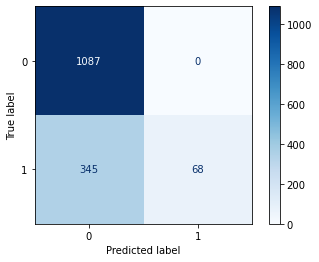

In [365]:
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

Основные метрики из Classification report

In [366]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1087
           1       1.00      0.16      0.28       413

    accuracy                           0.77      1500
   macro avg       0.88      0.58      0.57      1500
weighted avg       0.83      0.77      0.70      1500



In [367]:
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

F1-score = 0.283


Результаты исключение признаков - F1 score низкое и не меняется

|No features | F1 score|
|-|-|
|5 | 0.283|
|6|0.283|
|7|0.283|
|8|0.283|
|9|0.283|
|10|0.283|
|11|0.283|
|12|0.283|

# Обработка пропусков и выбросов

https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e

Идеи заполнения:
- knn https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e
- медианной по группе. Например заполнить Annual Income по Years of Credit History

In [7]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [24]:
df_train.isna().sum()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

Количество пропущенных значений по признакам:
```
Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
```

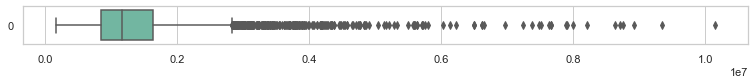

In [80]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Annual Income"], orient="h", palette="Set2")

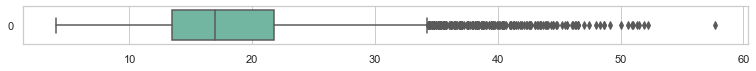

In [81]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Years of Credit History"], orient="h", palette="Set2")

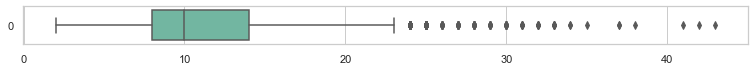

In [82]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Number of Open Accounts"], orient="h", palette="Set2")

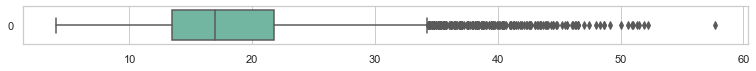

In [83]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Years of Credit History"], orient="h", palette="Set2")

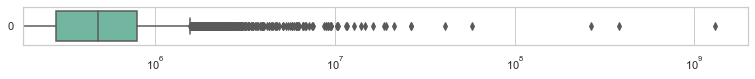

In [84]:
# логарифмическая шкала
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Maximum Open Credit"], orient="h", palette="Set2")
ax.set_xscale("log")

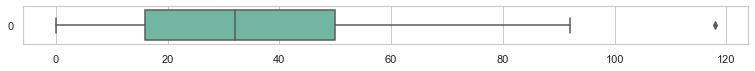

In [85]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Months since last delinquent"], orient="h", palette="Set2")

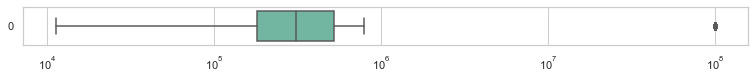

In [87]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Current Loan Amount"], orient="h", palette="Set2")
ax.set_xscale("log")

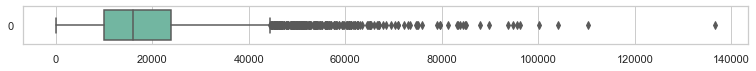

In [88]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Monthly Debt"], orient="h", palette="Set2")

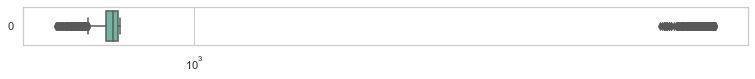

In [89]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 0.7)
ax = sns.boxplot(data=df_train["Credit Score"], orient="h", palette="Set2")
ax.set_xscale("log")

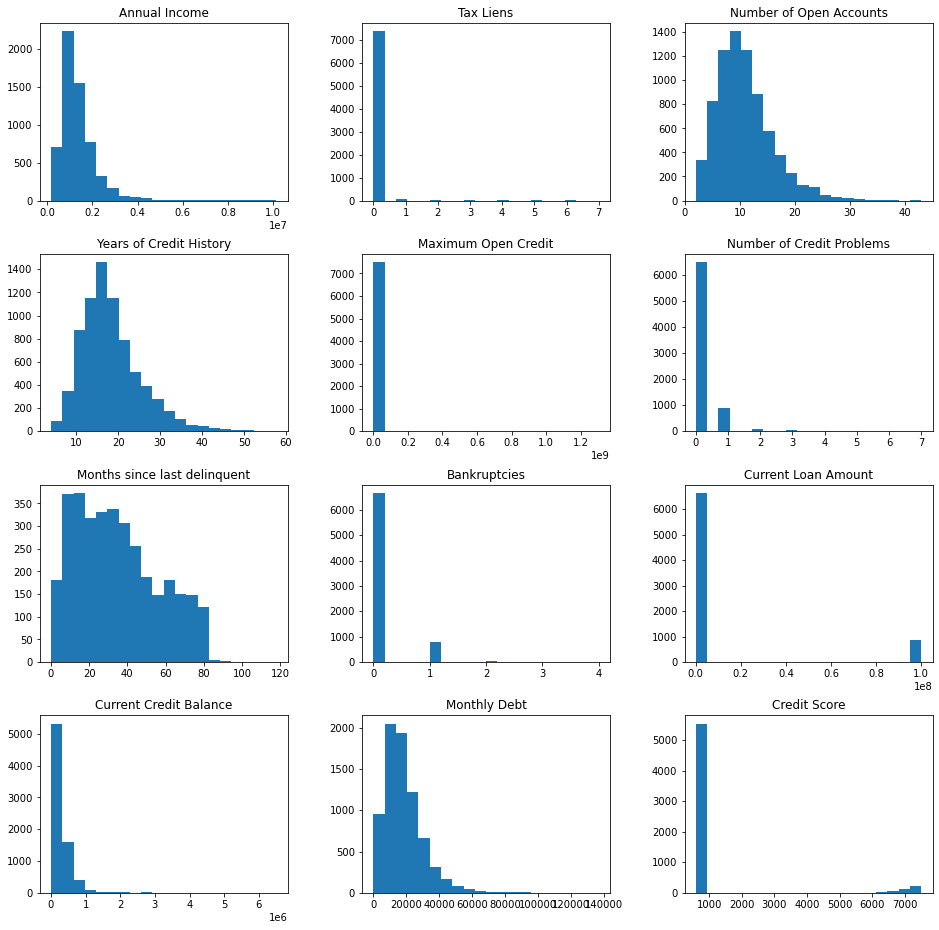

In [13]:
df_train[NUM_FEATURE_NAMES].hist(figsize=(16,16), bins=20, grid=False);

In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import StandardScaler


def imputer_rfr(data, target_col):
    data = data.copy()
    
    features = data.columns
    
    data = data[features]
    
    # на обучение подаём только те данные, где нет пропусков
    train = data[~data[target_col].isna()]
    # там где пропуски есть - данные для предсказания
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=10,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # R2 score потому что заполняем пропуски задачи регрессит
    print(f"r2 на train: {r2_score(y_train, pred_train)}")
    print(f"r2 на test: {r2_score(y_test, pred_test)}")

    # из датасета убираем целевой признак, делаем предсказание и 
    # в исходном датсете заменим пропуски данных на предсказание
    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [20]:
df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

Общее количество пропусков в каждом датасете

In [22]:
df_train_copy.isna().sum().sum()

7580

In [23]:
df_test_copy.isna().sum().sum()

2473

**Annual Income**

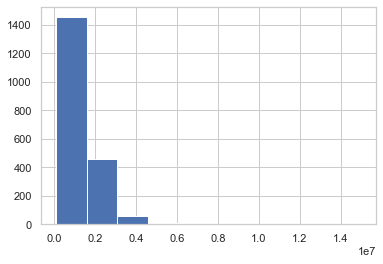

In [91]:
df_test['Annual Income'].hist();

In [115]:
# все признаки
FEATURES = df_train.columns.to_list()

TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
            'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# получаем категориальные признаки вычитая из всех признаков числовые и целевой признак
CAT_FEATURE_NAMES = [item for item in FEATURES if item not in NUM_FEATURE_NAMES]

CAT_FEATURE_NAMES.remove(TARGET_NAME)

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES #+ NEW_FEATURE_NAMES

In [119]:
# функция для замены выбросов на пропуски
def preprocess_outlier(df, col, threshold):
    # можно по threshold отсекать, а можно и по квантилям
    df.loc[df[col] > threshold, col] = np.nan
    return df

feature_name = 'Months since last delinquent'
df_train_copy = preprocess_outlier(df_train_copy, feature_name, threshold=500000)
df_test_copy = preprocess_outlier(df_test_copy, feature_name, threshold=500000)

df_train_copy[feature_name].isna().sum(), df_test_copy[feature_name].isna().sum()

(4081, 1358)

In [121]:
%%time
bill_Annual_Income_predictor, df_train_copy = imputer_rfr(df_train_copy[NUM_FEATURE_NAMES], feature_name)
#bill_Annual_Income_predictor, df_test_copy = imputer_rfr(df_test_copy[NUM_FEATURE_NAMES], feature_name)

ValueError: could not convert string to float: 'Home Mortgage'

# Анализ данных

In [94]:
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

**Проверим распределения вещественных признаков на трейне и тесте**

Сравним их распределения

нам нужно чтобы p-value было больше 5% иначе он какой то странный и на нём лучше не обучаться.

Annual Income
MannwhitneyuResult(statistic=7437874.5, pvalue=1.1638872141183186e-54)


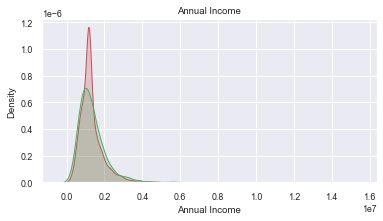

Tax Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


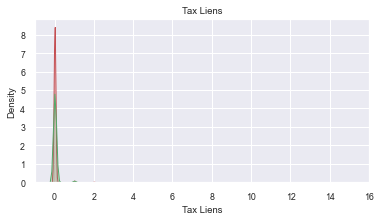

Number of Open Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


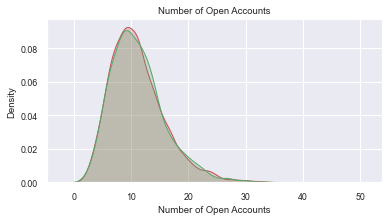

Years of Credit History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


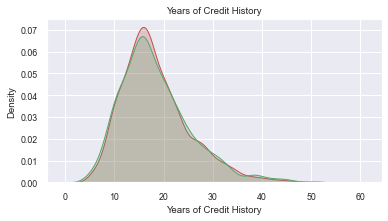

Maximum Open Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


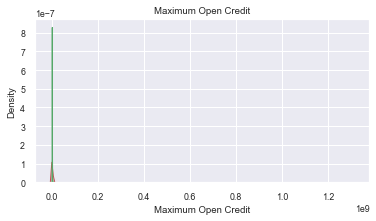

Number of Credit Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


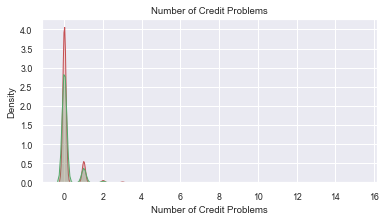

Months since last delinquent
MannwhitneyuResult(statistic=4446541.5, pvalue=0.0)


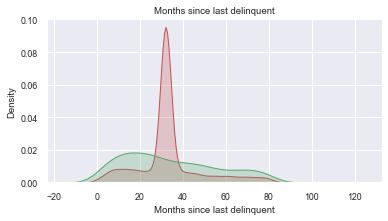

Bankruptcies
MannwhitneyuResult(statistic=9273462.0, pvalue=0.06499363911022255)


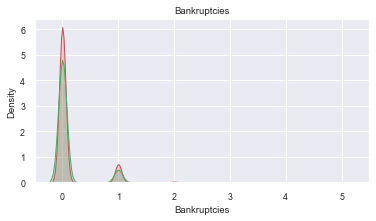

Current Loan Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


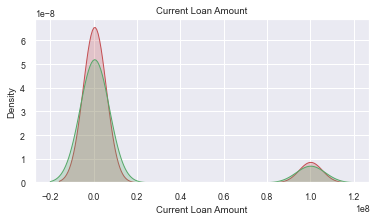

Current Credit Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


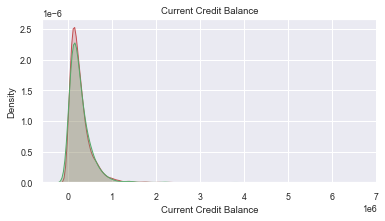

Monthly Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


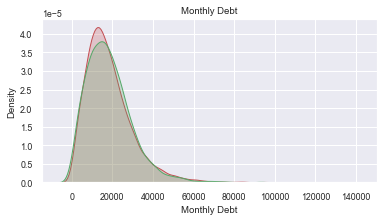

Credit Score
MannwhitneyuResult(statistic=7450960.5, pvalue=5.181190474654923e-54)


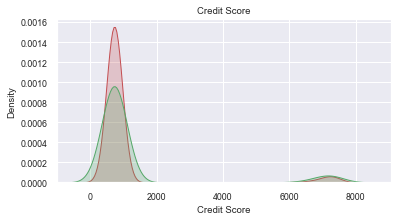

In [95]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.title(col)
    plt.show()

P-value < 0.05 имют признаки:
- Annual Income
- Months since last delinquent
- Credit Score

Построим модель без этих признаков:

{'max_depth': 5, 'min_samples_leaf': 5}
Accuracy на трейне 0.7786666666666666
Accuracy на тесте 0.7673333333333333
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1087
           1       0.73      0.25      0.37       413

    accuracy                           0.77      1500
   macro avg       0.75      0.61      0.61      1500
weighted avg       0.76      0.77      0.72      1500

F1-score = 0.369
Wall time: 17.1 s


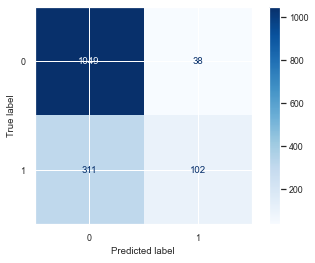

In [115]:
%%time

# Обновляем датасет
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

df_train.drop(columns=['Annual Income', 'Months since last delinquent', 'Credit Score', 'Credit Default'])
df_test.drop(columns=['Annual Income', 'Months since last delinquent', 'Credit Score'])

# Заполняем пропуски медианой
df_train = df_train.fillna(df_train.median(axis=0), axis=0)

# Переводим категориальные признаки в количественные
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# Формируем выборки
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

# Подбираем гиперпараметры
tree = DecisionTreeClassifier(random_state=1)

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

print(grid_search.best_params_)

# Предсказываем значения трейновой и тестовой выборки
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

#Подсчитываем метрики
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

print(classification_report(y_test, pred_test))
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

Исключение 3-х признаков не увеличило скор.

Обновляем датасет

In [105]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

**Проверим распределения категориальных признаков на трейне и тесте**

Целевая переменная есть только на трейне и нам нужно как-то выкручиваться, чтобы понимать насколько выборки между собой похожи.

Years of Credit History имел самый высокий уровень значимости, значит в его разрезе будем смотреть на категории.

Нужно чтобы зелёные (тест) доверительные интервалы были похожи на красные (трейн).

Purpuse трейна имеет на 1 значение больше чем теста.

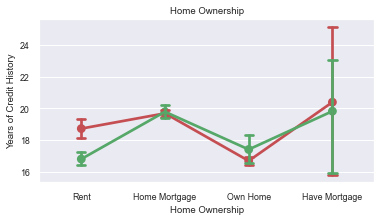

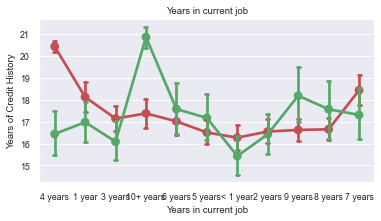

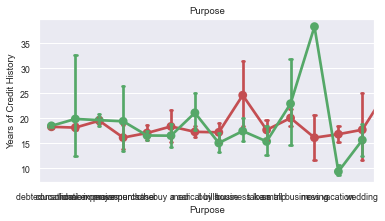

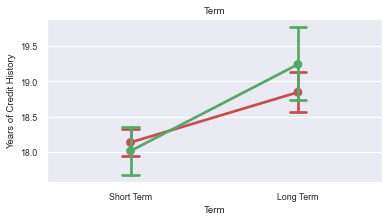

In [106]:
num_feature = 'Years of Credit History'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col) 
    plt.show()

Построим доверительные интервалы по признаку Maximum Open Credit.

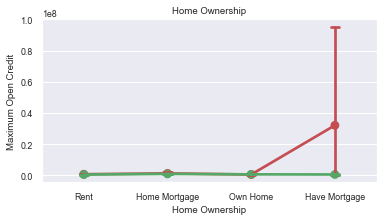

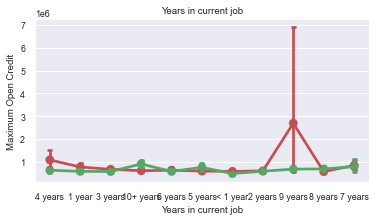

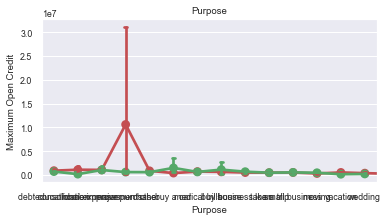

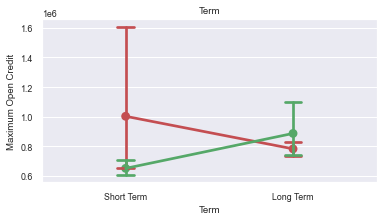

In [108]:
num_feature = 'Maximum Open Credit'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

Построим доверительные интервалы по признаку Current Credit Balance

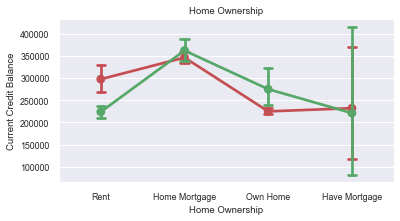

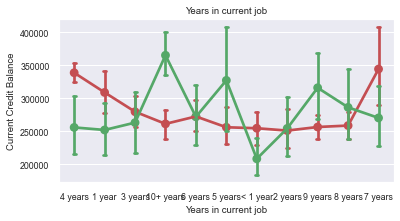

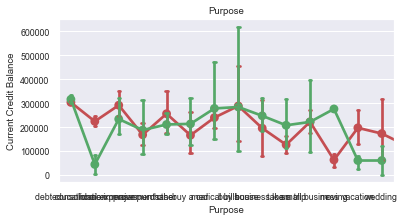

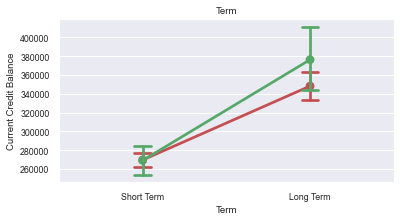

In [109]:
num_feature = 'Current Credit Balance'
for col in CAT_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
    sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    plt.title(col)
    plt.show()

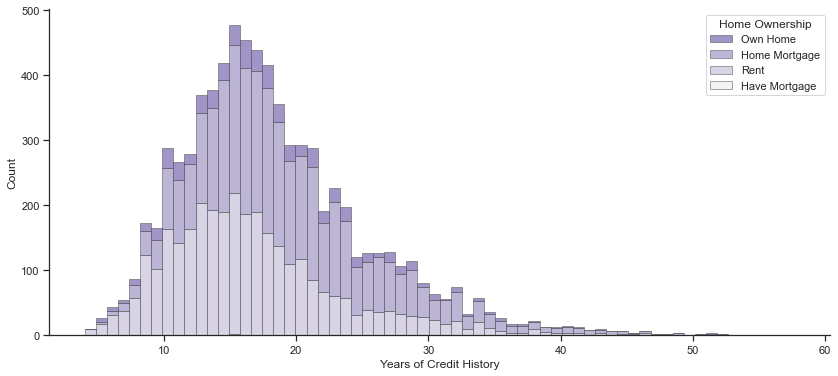

In [143]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(14, 6))
sns.despine(f)

sns.histplot(
    df_train,
    x="Years of Credit History", hue="Home Ownership",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    #log_scale=True,
)
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
#ax.set_xticks([500, 1000, 2000, 5000, 10000])

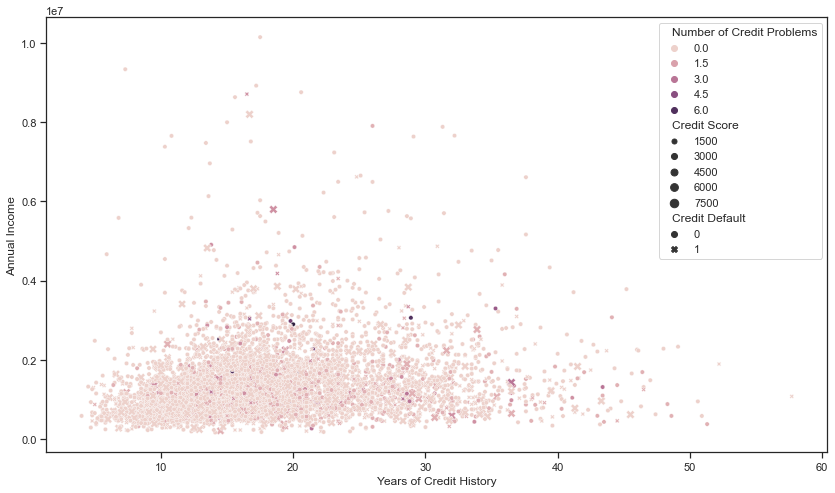

In [154]:
fig, ax = plt.subplots(figsize=(14,8)) 
sns.scatterplot(data=df_train, x="Years of Credit History", y="Annual Income",
                size='Credit Score', 
                style="Credit Default",
                hue='Number of Credit Problems',
               );

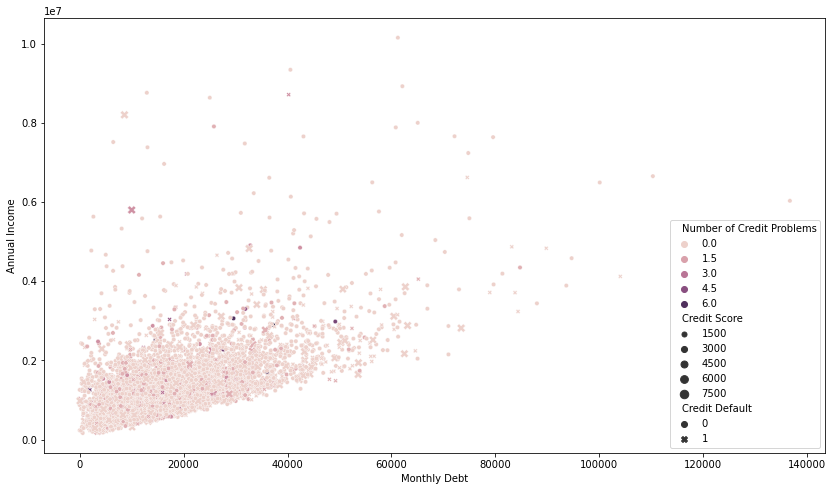

In [15]:
fig, ax = plt.subplots(figsize=(14,8)) 
sns.scatterplot(data=df_train, x="Monthly Debt", y="Annual Income",
                size='Credit Score', 
                style="Credit Default",
                hue='Number of Credit Problems',
               );

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

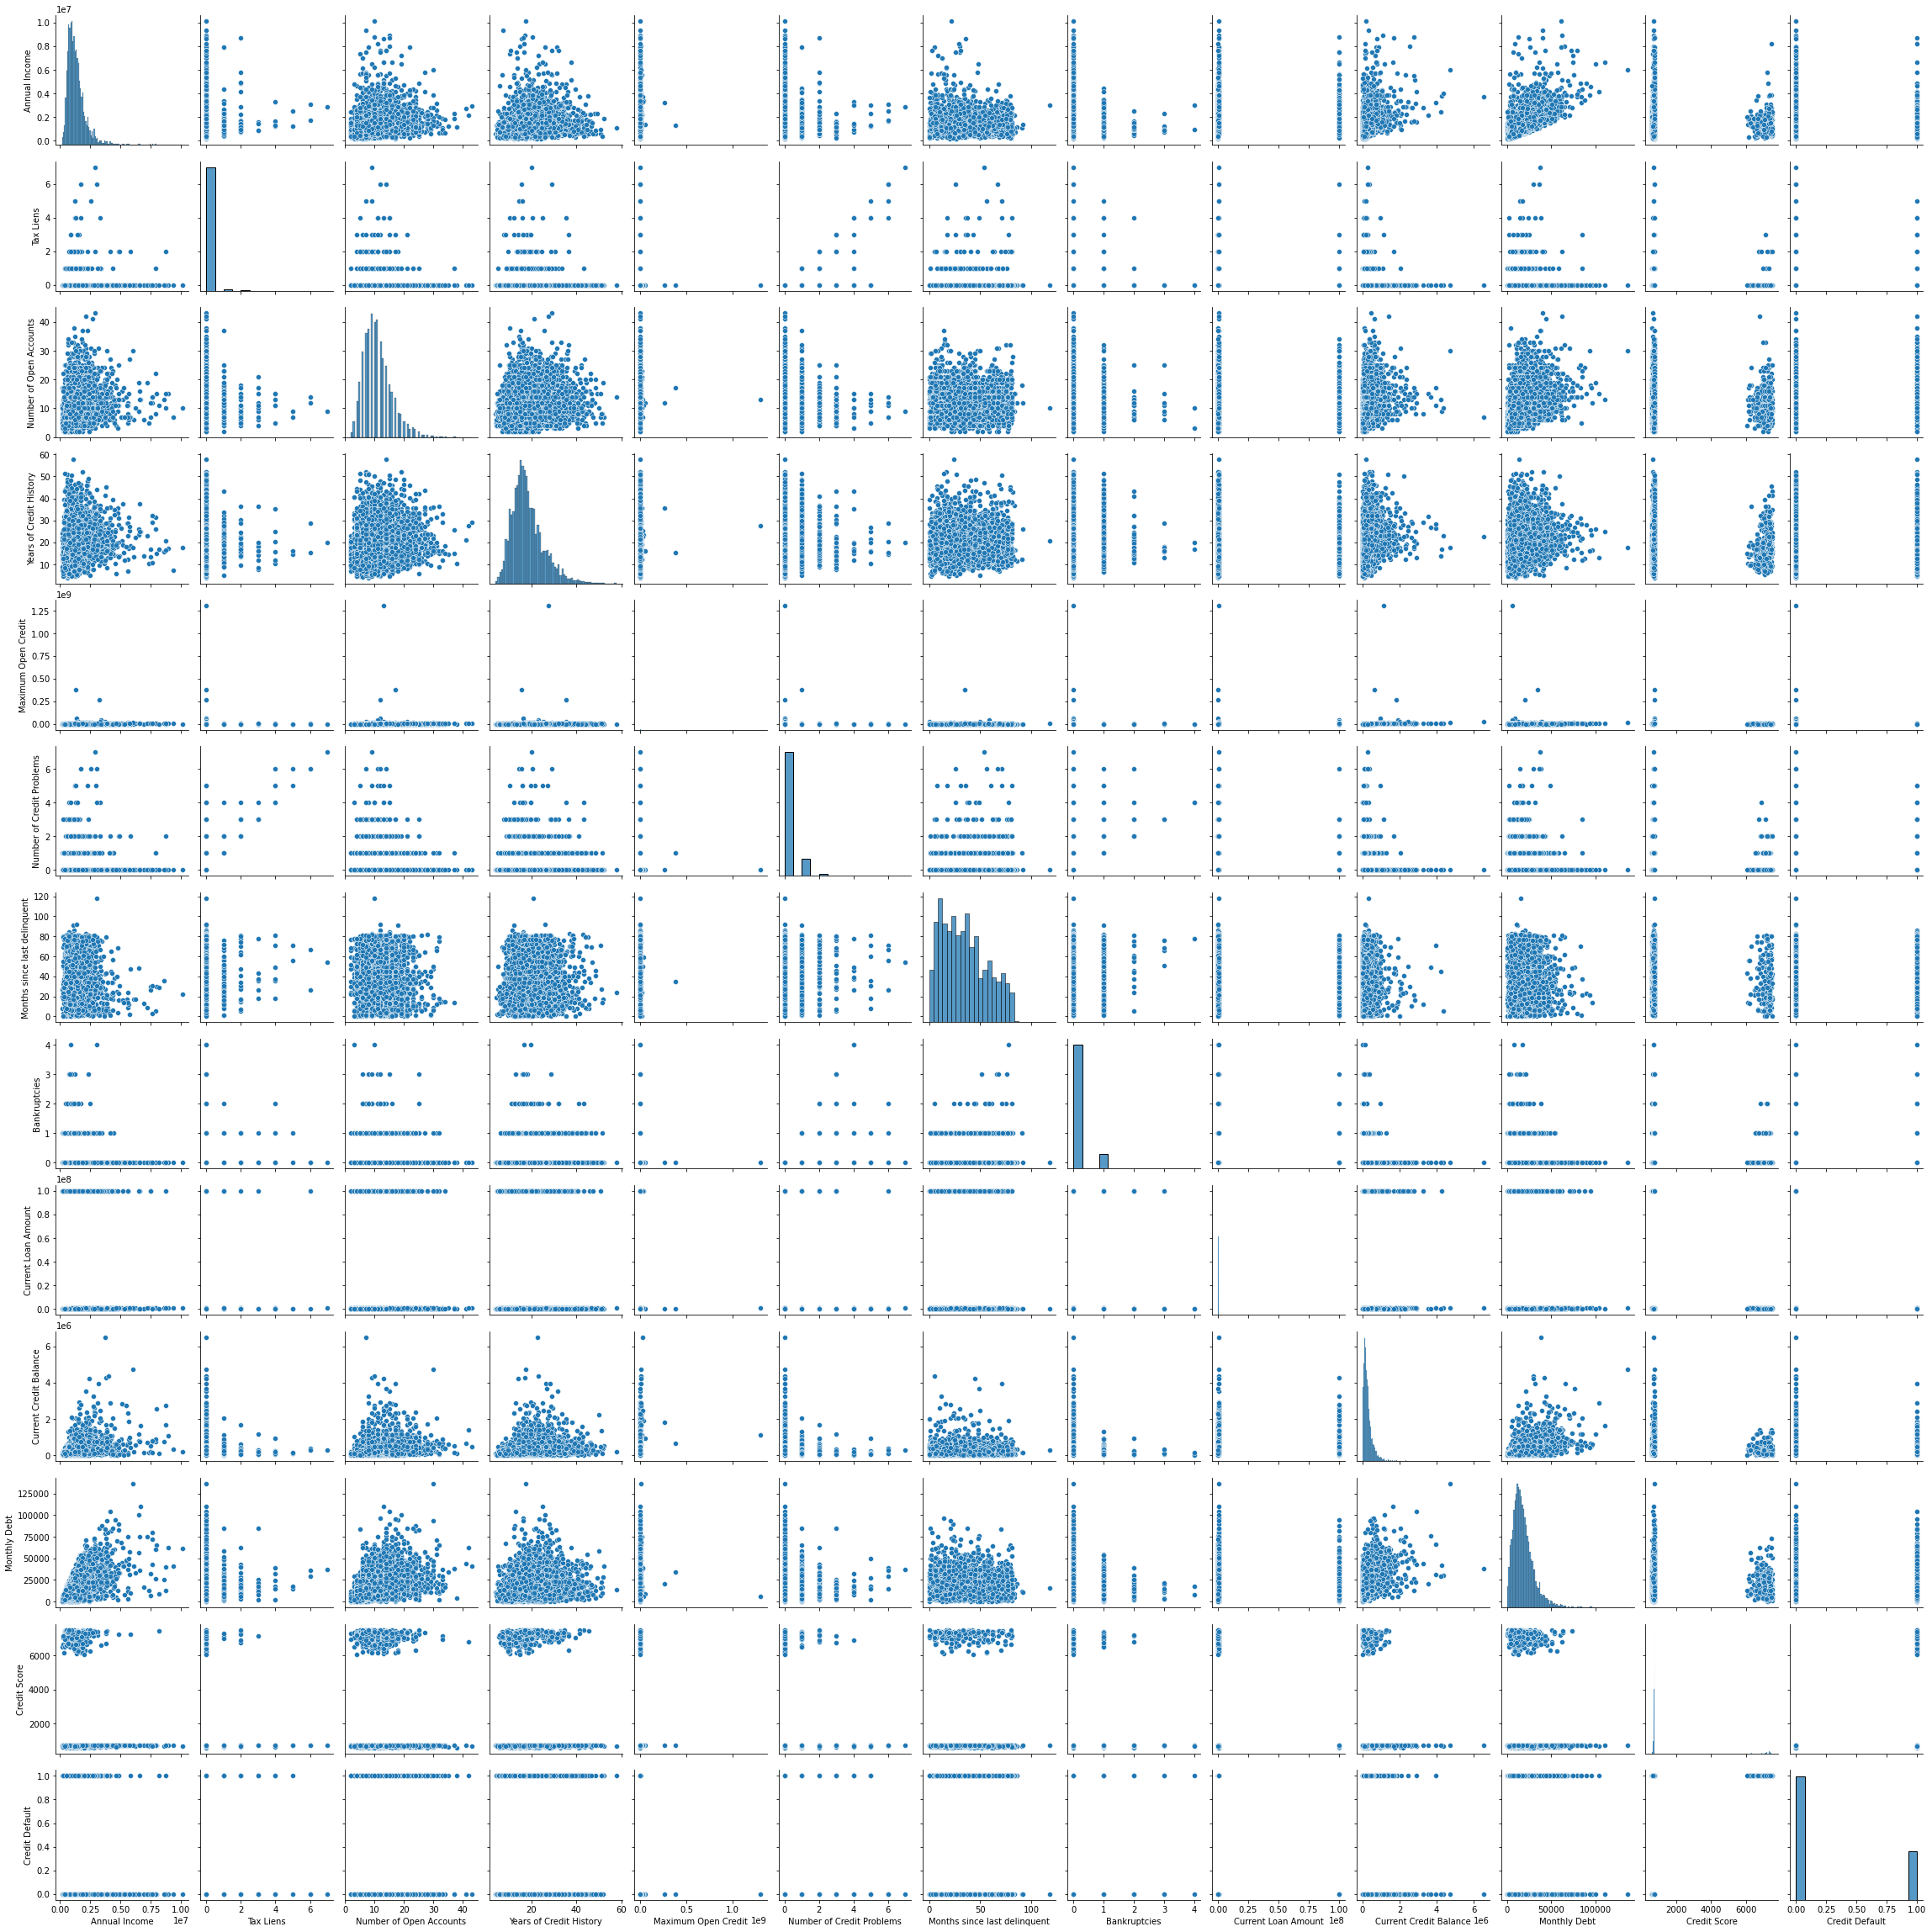

In [17]:
sns.pairplot(df_train)

In [58]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

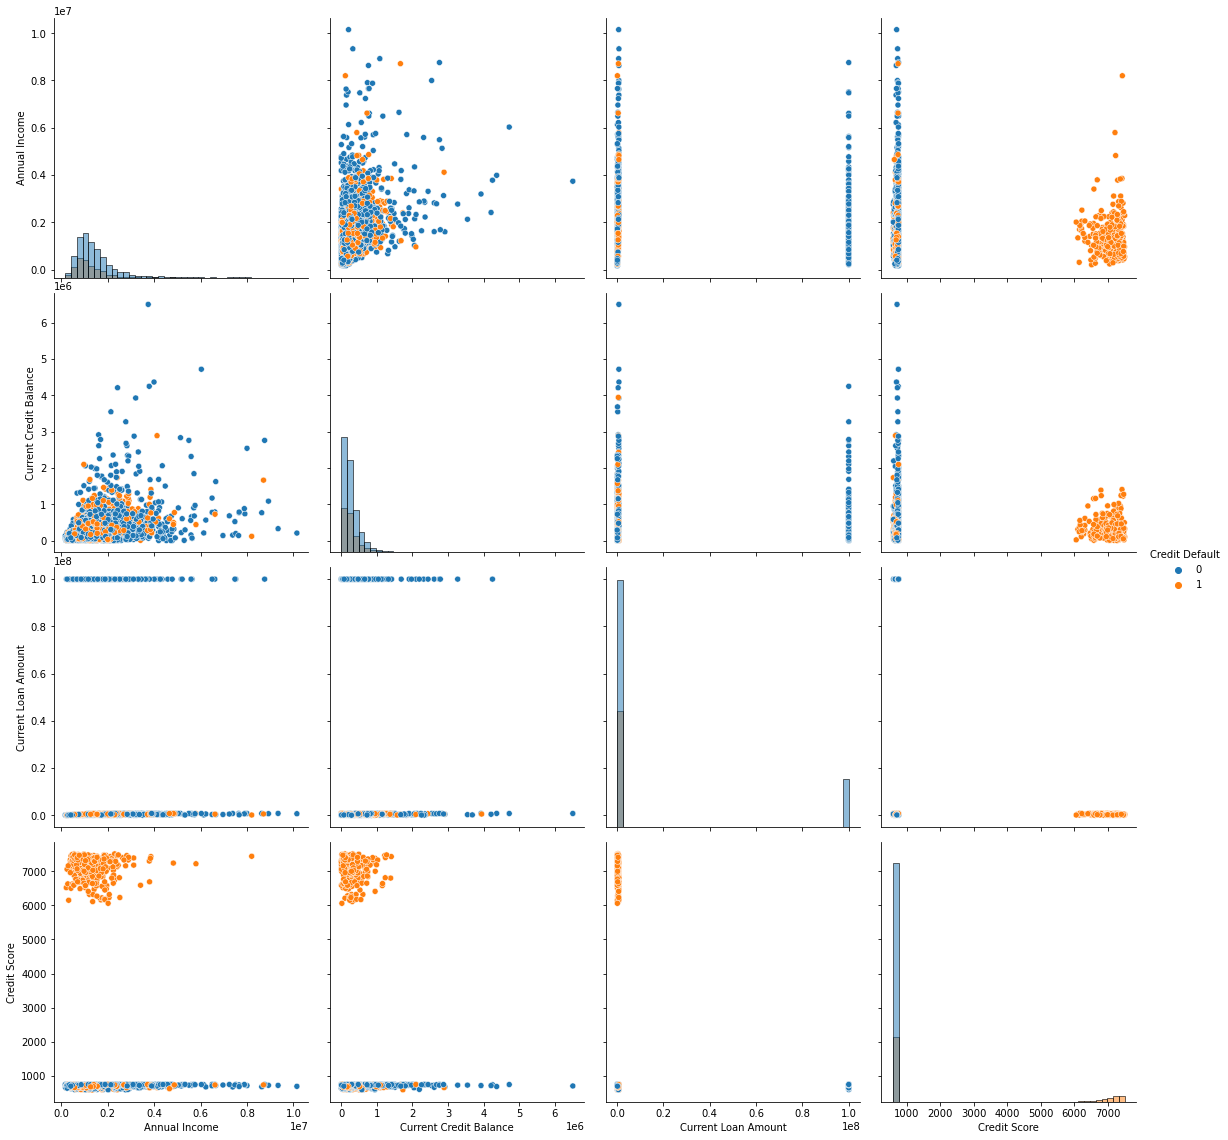

In [60]:
# https://seaborn.pydata.org/generated/seaborn.PairGrid.html
# Create an instance of the PairGrid class.
grid = sns.PairGrid(data=df_train, hue='Credit Default',
                    vars = ['Annual Income', 'Current Credit Balance', 
                    'Current Loan Amount', 'Credit Score'], size = 4)
# for all plots
#grid.map(sns.scatterplot)

# Map a scatter plot to the upper triangle
#grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(sns.scatterplot)

# # Map a histogram to the diagonal
#grid = grid.map_diag(plt.hist, bins = 10, color = 'darkred', edgecolor = 'k')
grid.map_diag(sns.histplot, bins = 40)

# Map a density plot to the lower triangle
# grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')
grid = grid.map_lower(sns.scatterplot)
grid.add_legend();

У объектов с Current Loan Amount = 1 всегда Credit Default = 1

У объектов с Credit score > 6000, Credit Default = 1

Можно попробавть заполнить пропуски по Current Loan Amount.

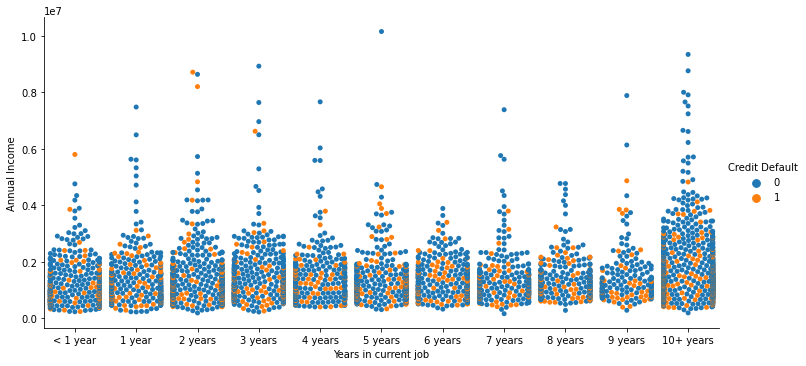

In [112]:
sns.catplot(x="Years in current job", y="Annual Income", hue="Credit Default", 
            kind="swarm", aspect=2, data=df_train,
            order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                  '6 years', '7 years', '8 years', '9 years', '10+ years']);

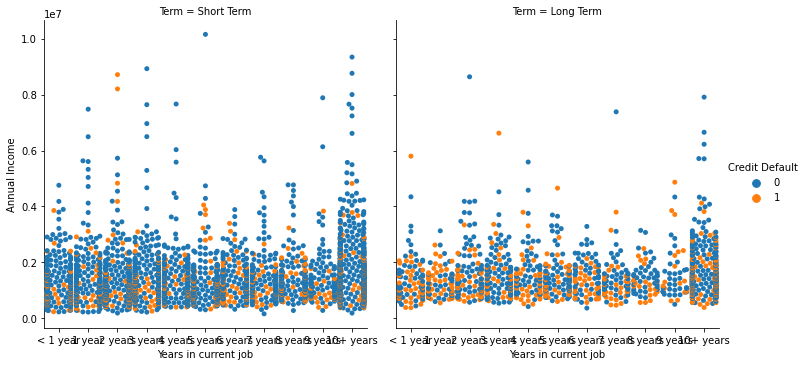

In [113]:
sns.catplot(x="Years in current job", y="Annual Income", 
            hue="Credit Default", col="Term", 
            aspect=1, kind="swarm", data=df_train,
            order=['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years',
                  '6 years', '7 years', '8 years', '9 years', '10+ years']);

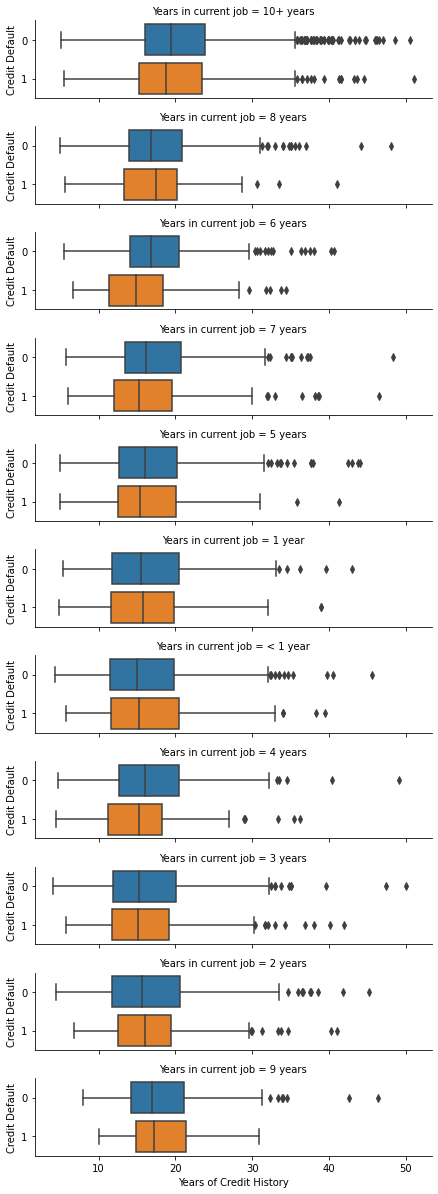

In [106]:
g = sns.catplot(x="Years of Credit History", y='Credit Default', row='Years in current job',
                kind="box", orient="h", height=1.5, aspect=4,
                data=df_train)
g.set();
#https://seaborn.pydata.org/tutorial/categorical.html

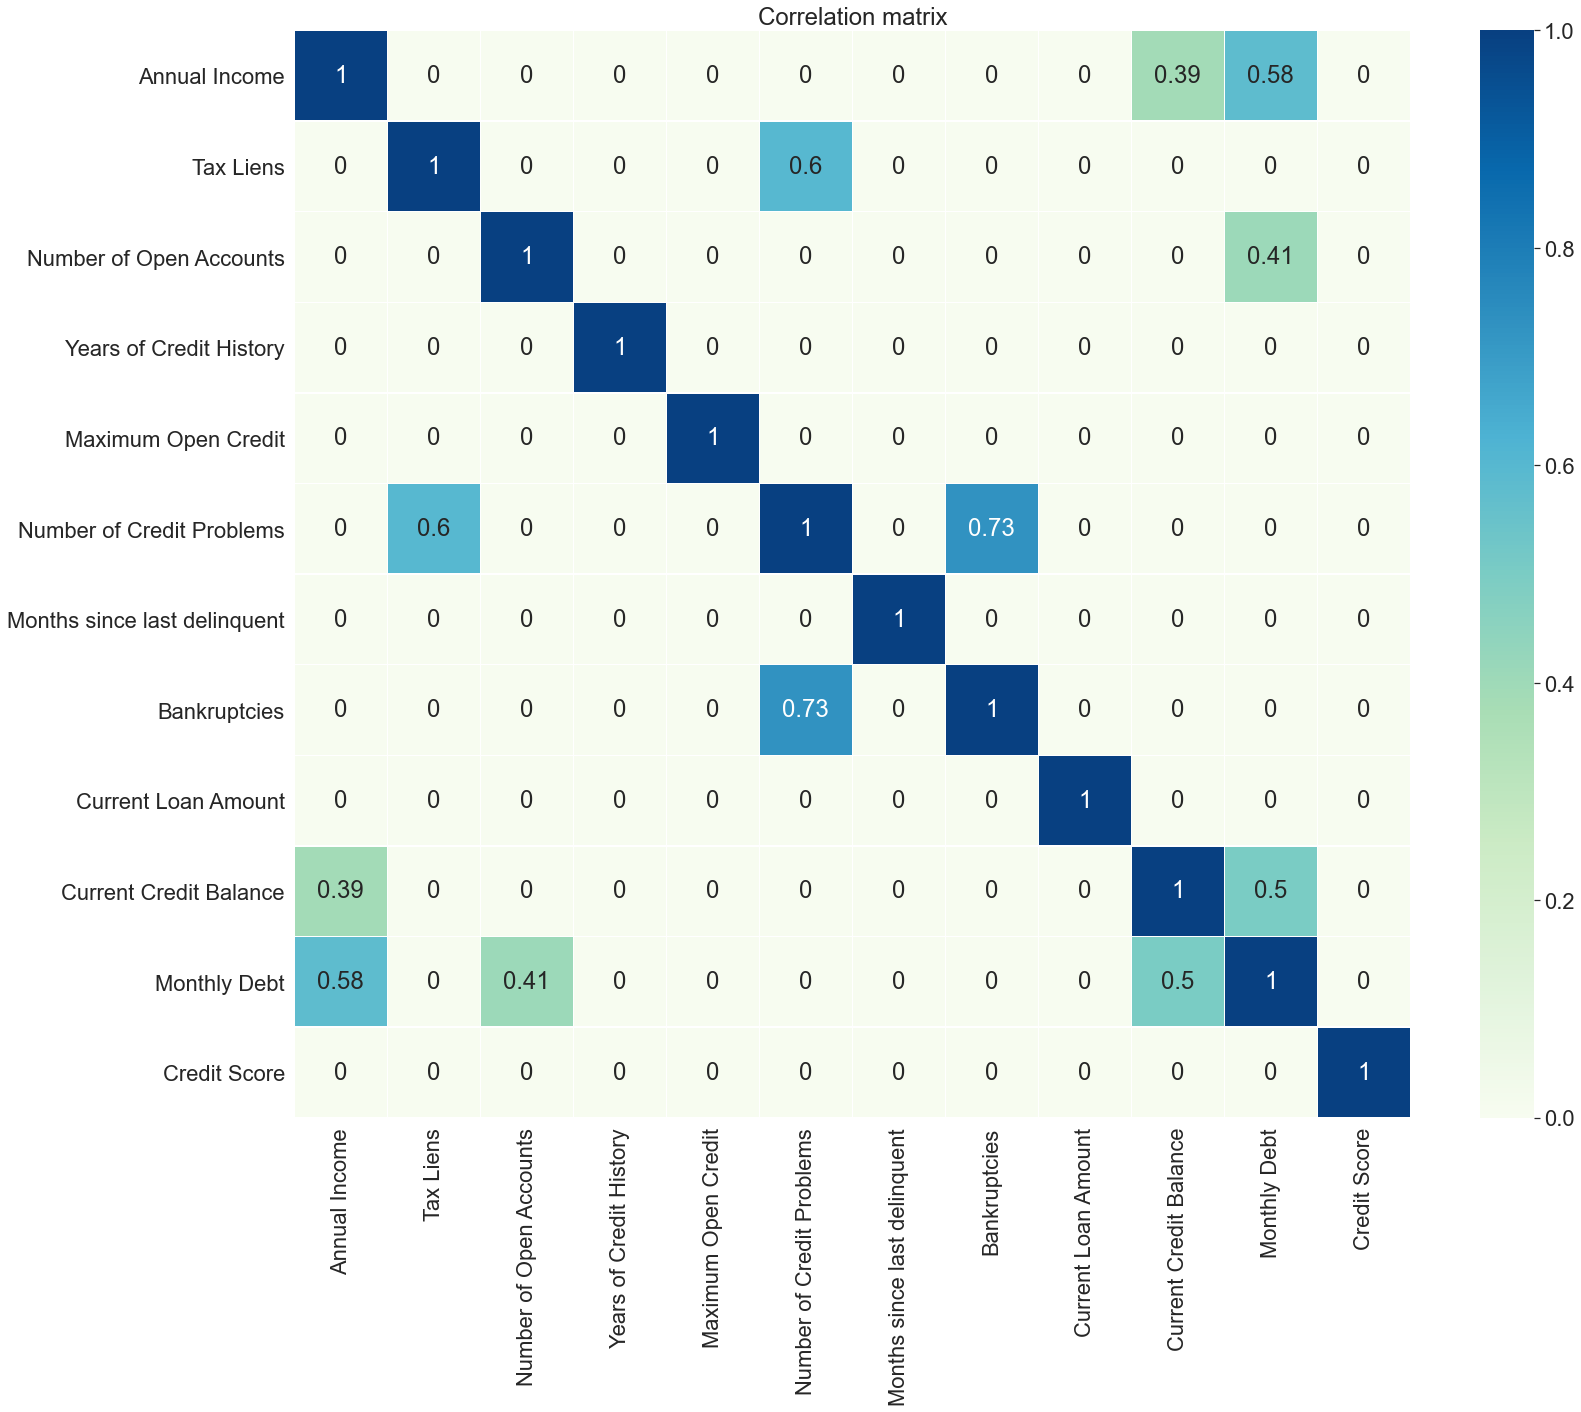

In [159]:
plt.figure(figsize = (25,20))

sns.set(font_scale=2)

corr_matrix = df_train[NUM_FEATURE_NAMES].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Посмотрим как распределяются категориальные признаки по предсказываемым классам.

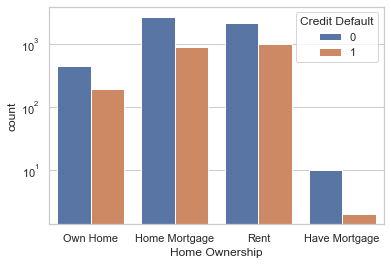

In [128]:
sns.countplot(df_train['Home Ownership'], hue=df_train['Credit Default'], log=True);

Люди, имеющие ипотеку допускают кредитный дефолт значительно реже.

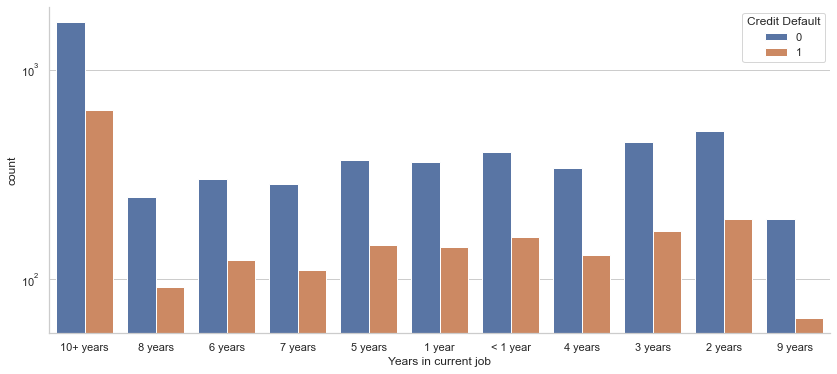

In [132]:
f, ax = plt.subplots(figsize=(14, 6))
sns.despine(f)
sns.countplot(df_train['Years in current job'], hue=df_train['Credit Default'], log=True);

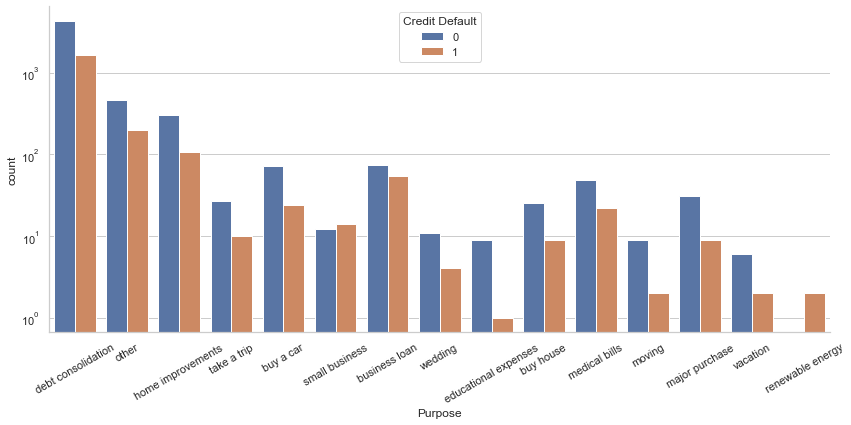

In [141]:
f, ax = plt.subplots(figsize=(14, 6))
sns.despine(f)
sns.countplot(df_train['Purpose'], hue=df_train['Credit Default'], log=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

Все кто брали кредит на renewable energy допустили кредитный дефолт.

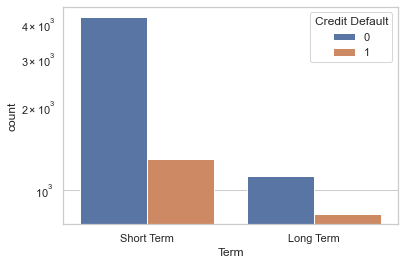

In [131]:
sns.countplot(df_train['Term'], hue=df_train['Credit Default'], log=True);

In [142]:
CAT_FEATURE_NAMES

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

# Отбор признаков

# Балансировка классов

In [120]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [121]:
5387/2113

2.549455750118315

Построим модель с весами для разных классов

{'max_depth': 1, 'min_samples_leaf': 1}
Accuracy на трейне 0.772
Accuracy на тесте 0.77
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1087
           1       1.00      0.16      0.28       413

    accuracy                           0.77      1500
   macro avg       0.88      0.58      0.57      1500
weighted avg       0.83      0.77      0.70      1500

F1-score = 0.283
Wall time: 17.9 s


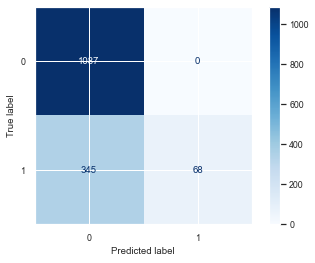

In [126]:
%%time

# Обновляем датасет
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

# Заполняем пропуски медианой
df_train = df_train.fillna(df_train.median(axis=0), axis=0)

# Переводим категориальные признаки в количественные
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)

# Формируем выборки
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)

# Подбираем гиперпараметры
tree = DecisionTreeClassifier(random_state=1, class_weight={0:1, 1:2.55})

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

print(grid_search.best_params_)

# Предсказываем значения трейновой и тестовой выборки
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

#Подсчитываем метрики
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

print(classification_report(y_test, pred_test))
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

```
class_weight={0:2.55, 1:1}  F1 = 0.294
class_weight={0:1, 1:2.55}  F1 = 0.283
```

# Подбор моделей, получение бейзлана

Обновляем датасет

In [16]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Заполняем пропуски медианой

In [17]:
df_train = df_train.fillna(df_train.median(axis=0), axis=0)
#df_train = df_train.fillna(df_train.mode()[0:])
df_train.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                          32.0           1.0   
1                        0.0                          32.0           0.0   
2                        0.0                          32.0           0.0   
3                        1.0                          32.0           1.0   
4                        1.0                          32.0           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

Переводим категориальные признаки в количественные

In [10]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)
df_train.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Credit Default',
       'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Years in current job_1 year', 'Years in current job_10+ years',
       'Years in current job_2 years', 'Years in current job_3 years',
       'Years in current job_4 years', 'Years in current job_5 years',
       'Years in current job_6 years', 'Years in current job_7 years',
       'Years in current job_8 years', 'Years in current job_9 years',
       'Years in current job_< 1 year', 'Purpose_business loan',
       'Purpose_buy a car', 'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home i

Выделение целевой переменной и групп признаков. Отбор признаков

In [11]:
# все признаки
FEATURES = df_train.columns.to_list()

TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
            'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# получаем категориальные признаки вычитая из всех признаков числовые и целевой признак
CAT_FEATURE_NAMES = [item for item in FEATURES if item not in NUM_FEATURE_NAMES]

CAT_FEATURE_NAMES.remove(TARGET_NAME)

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES #+ NEW_FEATURE_NAMES

Стандартизация данных

In [12]:
scaler = StandardScaler()

df_train_norm = df_train.copy()
df_train_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_train_norm[NUM_FEATURE_NAMES])

df_train = df_train_norm.copy()

Разбиение на train и test

In [13]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [14]:
X_train.columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Years in current job_1 year',
       'Years in current job_10+ years', 'Years in current job_2 years',
       'Years in current job_3 years', 'Years in current job_4 years',
       'Years in current job_5 years', 'Years in current job_6 years',
       'Years in current job_7 years', 'Years in current job_8 years',
       'Years in current job_9 years', 'Years in current job_< 1 year',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Pur

## Построение и оценка базовых моделей<a class="anchor" id="baseline_modeling"></a> 

**Логистическая регрессия**

In [15]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

evaluate_preds(model_lr, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.78      0.98      0.86      3771
           1       0.82      0.28      0.42      1479

    accuracy                           0.78      5250
   macro avg       0.80      0.63      0.64      5250
weighted avg       0.79      0.78      0.74      5250

TEST

              precision    recall  f1-score   support

           0       0.76      0.97      0.86      1616
           1       0.78      0.23      0.36       634

    accuracy                           0.77      2250
   macro avg       0.77      0.60      0.61      2250
weighted avg       0.77      0.77      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1575   41
1                486  148


**k ближайших соседей**

In [18]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

evaluate_preds(model_knn, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      3771
           1       0.76      0.49      0.60      1479

    accuracy                           0.81      5250
   macro avg       0.79      0.72      0.74      5250
weighted avg       0.81      0.81      0.80      5250

TEST

              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1616
           1       0.52      0.31      0.39       634

    accuracy                           0.72      2250
   macro avg       0.64      0.60      0.61      2250
weighted avg       0.70      0.72      0.70      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1432  184
1                435  199


**Дерево решений**

Дисбаланс классов

In [294]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

In [20]:
class_weight = df_train['Credit Default'].value_counts()[1] / df_train['Credit Default'].value_counts()[0]
class_weight

0.39224057917208094

In [21]:
df_train['Credit Default'].value_counts()

5387/2113# class_weight - веса для разных классов т.к. дисбаланс классов.
# В 3,6 раз объектов 1-го класса больше чем нулевого
model_tree = DecisionTreeClassifier(random_state=21,
                                    class_weight={0:class_weight, 1:1},
                                    max_depth=4
                                    )
model_tree.fit(X_train, y_train)

evaluate_preds(model_tree, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      3771
           1       0.53      0.51      0.52      1479

    accuracy                           0.73      5250
   macro avg       0.67      0.67      0.67      5250
weighted avg       0.73      0.73      0.73      5250

TEST

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      1616
           1       0.51      0.49      0.50       634

    accuracy                           0.72      2250
   macro avg       0.65      0.65      0.65      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1312  304
1                322  312


**Бустинговые алгоритмы**

*XGBoost*

Т.к. в трейне и тесте после перевода в категориальные данные появляется столбец 'Years in current job_< 1 year', то необходимо заменить знак < на _ . Иначе появляется ошибка `ValueError('feature_names may not contain [, ] or <')`

In [22]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_xgb = X_train
X_test_xgb = X_test
X_train_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) \
                   else col for col in X_train.columns.values]
X_test_xgb.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) \
                  else col for col in X_test.columns.values]

In [23]:
%%time

model_xgb = xgb.XGBClassifier(random_state=21,
#                               n_estimators=100
                             )
model_xgb.fit(X_train, y_train)

evaluate_preds(model_xgb, X_train_xgb, X_test_xgb, y_train, y_test)

[15:39:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3771
           1       0.99      0.85      0.92      1479

    accuracy                           0.96      5250
   macro avg       0.97      0.92      0.94      5250
weighted avg       0.96      0.96      0.96      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.90      0.84      1616
           1       0.59      0.35      0.44       634

    accuracy                           0.75      2250
   macro avg       0.68      0.63      0.64      2250
weighted avg       0.73      0.75      0.73      2250

CONFUSION MATRIX

col_0

*LightGBM*

In [24]:
%%time
model_lgbm = lgbm.LGBMClassifier(random_state=21, 
                                 class_weight={0:class_weight, 1:1},
#                                  n_estimators=100
                                )
model_lgbm.fit(X_train, y_train)

evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      3771
           1       0.84      0.95      0.89      1479

    accuracy                           0.93      5250
   macro avg       0.91      0.94      0.92      5250
weighted avg       0.94      0.93      0.94      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1616
           1       0.50      0.53      0.52       634

    accuracy                           0.72      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1276  340
1                295  339
Wall time: 197 ms


*CatBoost*

In [25]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     #cat_features=CAT_FEATURE_NAMES
                                    )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      3771
           1       0.97      0.57      0.72      1479

    accuracy                           0.87      5250
   macro avg       0.91      0.78      0.82      5250
weighted avg       0.89      0.87      0.86      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.86      1616
           1       0.72      0.32      0.44       634

    accuracy                           0.77      2250
   macro avg       0.75      0.64      0.65      2250
weighted avg       0.76      0.77      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1538   78
1                431  203
Wall time: 3.91 s


**Лучший F1-score=0.51 получился на алгоритме LightGBM**

Попробуем настроить CatBoost который с параметрами по умолчанию выдал метрику 0.44.

## Подготовка для catboost

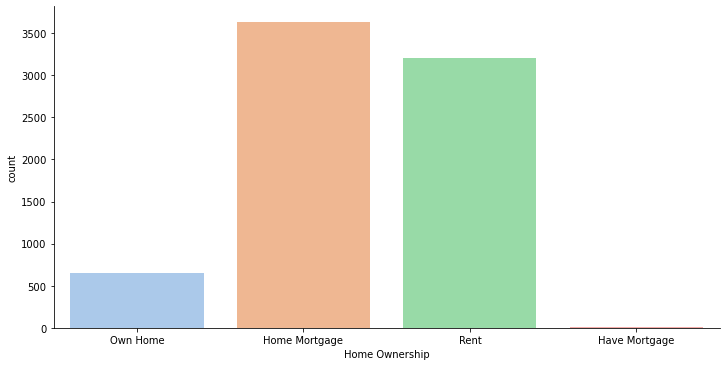

In [9]:
sns.catplot(x=df_train[CAT_FEATURE_NAMES[0]], kind="count", palette="pastel", data=df_train, aspect=2);

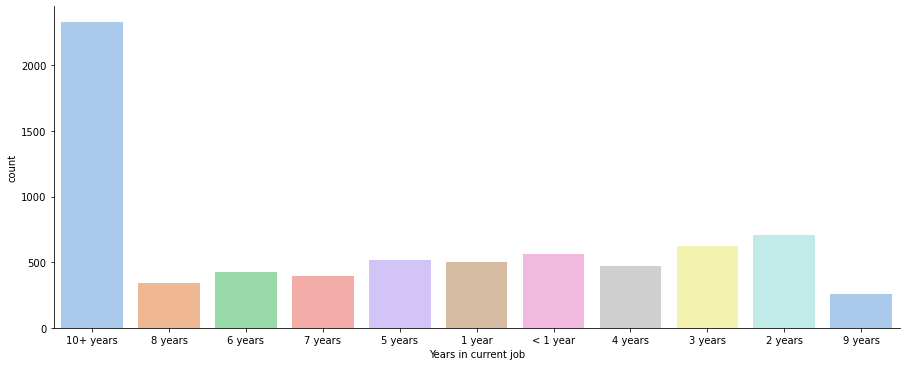

In [10]:
sns.catplot(x=df_train[CAT_FEATURE_NAMES[1]], kind="count", palette="pastel", data=df_train, aspect=2.5);

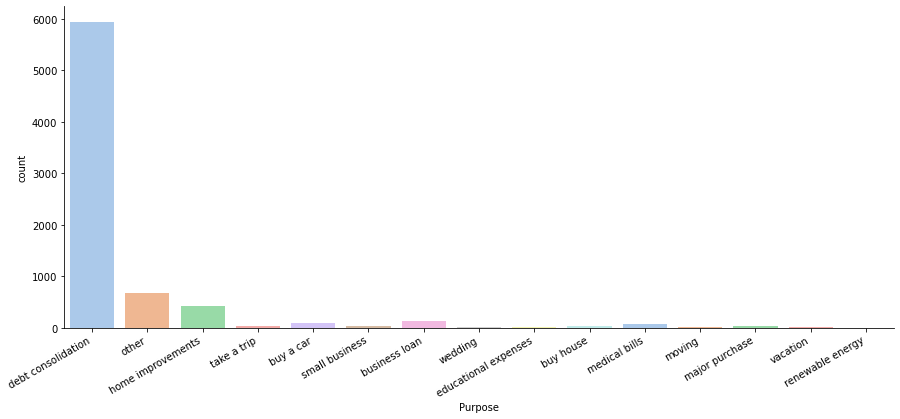

In [11]:
ax = sns.catplot(x=df_train[CAT_FEATURE_NAMES[2]], kind="count", data=df_train, 
                 aspect=2.5, palette="pastel", margin_titles=True)
ax.set_xticklabels(rotation=30, ha="right");

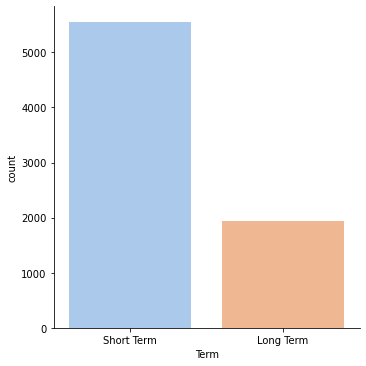

In [12]:
sns.catplot(x=df_train[CAT_FEATURE_NAMES[3]], kind="count", palette="pastel", data=df_train);

In [13]:
df_train['Annual Income'].mean()

1366391.7201749957

Обновляем датасет

In [145]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [146]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [88]:
df_train.head(10)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   
5           Rent            NaN              7 years        0.0   
6  Home Mortgage      1511108.0            10+ years        0.0   
7           Rent      1040060.0            10+ years        0.0   
8  Home Mortgage            NaN              5 years        0.0   
9  Home Mortgage            NaN               1 year        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   
6                      9.0                     20.3             388124.0   
7                     13.0                     12.0             330374.0   
8                     17.0                     15.7                  0.0   
9                     10.0                     24.6             511302.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   
5                        0.0                           NaN           0.0   
6                        0.0                          73.0           0.0   
7                        0.0                          18.0           0.0   
8                        1.0                           NaN           1.0   
9                        0.0                           6.0           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   
5               other   Long Term             337304.0   
6   home improvements  Short Term           99999999.0   
7               other  Short Term             250888.0   
8   home improvements  Short Term             129734.0   
9  debt consolidation   Long Term             572880.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0  
5                165680.0       18692.0           NaN               1  
6                 51623.0        2317.0         745.0               0  
7                 89015.0       19761.0         705.0               1  
8                    19.0          17.0           NaN               0  
9                205333.0       17613.0           NaN               1

Заполняем пропуски модой

In [147]:
df_train.fillna(df_train.mode().iloc[0], inplace=True)
df_train.head(10)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0            10+ years        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   
5           Rent       969475.0              7 years        0.0   
6  Home Mortgage      1511108.0            10+ years        0.0   
7           Rent      1040060.0            10+ years        0.0   
8  Home Mortgage       969475.0              5 years        0.0   
9  Home Mortgage       969475.0               1 year        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   
6                      9.0                     20.3             388124.0   
7                     13.0                     12.0             330374.0   
8                     17.0                     15.7                  0.0   
9                     10.0                     24.6             511302.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                          14.0           1.0   
1                        0.0                          14.0           0.0   
2                        0.0                          14.0           0.0   
3                        1.0                          14.0           1.0   
4                        1.0                          14.0           0.0   
5                        0.0                          14.0           0.0   
6                        0.0                          73.0           0.0   
7                        0.0                          18.0           0.0   
8                        1.0                          14.0           1.0   
9                        0.0                           6.0           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   
5               other   Long Term             337304.0   
6   home improvements  Short Term           99999999.0   
7               other  Short Term             250888.0   
8   home improvements  Short Term             129734.0   
9  debt consolidation   Long Term             572880.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0  
5                165680.0       18692.0         740.0               1  
6                 51623.0        2317.0         745.0               0  
7                 89015.0       19761.0         705.0               1  
8                    19.0          17.0         740.0               0  
9                205333.0       17613.0         740.0               1

Заполняем пропуски медианой

In [96]:
# заполнение пропусков медианой
df = df_train.apply(lambda x:x.fillna(x.value_counts().index[0]))
df_train = df
df_train.head(10)

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0            10+ years        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   
5           Rent      1161660.0              7 years        0.0   
6  Home Mortgage      1511108.0            10+ years        0.0   
7           Rent      1040060.0            10+ years        0.0   
8  Home Mortgage      1161660.0              5 years        0.0   
9  Home Mortgage      1161660.0               1 year        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   
5                     12.0                     14.6             366784.0   
6                      9.0                     20.3             388124.0   
7                     13.0                     12.0             330374.0   
8                     17.0                     15.7                  0.0   
9                     10.0                     24.6             511302.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                          14.0           1.0   
1                        0.0                          14.0           0.0   
2                        0.0                          14.0           0.0   
3                        1.0                          14.0           1.0   
4                        1.0                          14.0           0.0   
5                        0.0                          14.0           0.0   
6                        0.0                          73.0           0.0   
7                        0.0                          18.0           0.0   
8                        1.0                          14.0           1.0   
9                        0.0                           6.0           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   
5               other   Long Term             337304.0   
6   home improvements  Short Term           99999999.0   
7               other  Short Term             250888.0   
8   home improvements  Short Term             129734.0   
9  debt consolidation   Long Term             572880.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0  
5                165680.0       18692.0         740.0               1  
6                 51623.0        2317.0         745.0               0  
7                 89015.0       19761.0         705.0               1  
8                    19.0          17.0         740.0               0  
9                205333.0       17613.0         740.0               1

In [148]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Выделение целевой переменной и групп признаков. Отбор признаков

In [149]:
# все признаки
FEATURES = df_train.columns.to_list()

TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
            'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# получаем категориальные признаки вычитая из всех признаков числовые и целевой признак
CAT_FEATURE_NAMES = [item for item in FEATURES if item not in NUM_FEATURE_NAMES]

CAT_FEATURE_NAMES.remove(TARGET_NAME)

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES #+ NEW_FEATURE_NAMES

In [150]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [75]:
print(SELECTED_FEATURE_NAMES)

['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score', 'Home Ownership', 'Years in current job', 'Purpose', 'Term']


In [76]:
print(CAT_FEATURE_NAMES)

['Home Ownership', 'Years in current job', 'Purpose', 'Term']


In [77]:
print(TARGET_NAME)

Credit Default


In [78]:
X_train.iloc[45:48,12:14]

Home Ownership Years in current job
6052           Rent              5 years
3743  Home Mortgage            10+ years
2885  Home Mortgage            10+ years

In [151]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     one_hot_max_size=12
                                    )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.99      0.92      3771
           1       0.97      0.56      0.71      1479

    accuracy                           0.87      5250
   macro avg       0.91      0.78      0.81      5250
weighted avg       0.88      0.87      0.86      5250

TEST

              precision    recall  f1-score   support

           0       0.78      0.95      0.85      1616
           1       0.69      0.31      0.43       634

    accuracy                           0.77      2250
   macro avg       0.74      0.63      0.64      2250
weighted avg       0.75      0.77      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1528   88
1                435  199
Wall time: 18.1 s


F1 = 0.43 с заполнением медианой

F1 = 0.43 с заполнением модой

## Балансировка

Для CatBoost не нужно переводить категориальные признаки в числовые. Он сделает это сам.

Но по умолчанию CatBoost воспринимает как категориальные признаки только с 2-мя уникальными значениями. Если признак имеет больше чем 2 уникальных значения, то он будет считаться не категорийным. Параметр one_hot_max_size позволяет изменить это.

In [152]:
class_weight = df_train['Credit Default'].value_counts()[1] / df_train['Credit Default'].value_counts()[0]
class_weight

0.39224057917208094

In [153]:
%%time

model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     one_hot_max_size=12,
                                     class_weights=[class_weight, 1]
                                    )
model_catb.fit(X_train, y_train)

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.96      0.90      0.93      3771
           1       0.78      0.90      0.84      1479

    accuracy                           0.90      5250
   macro avg       0.87      0.90      0.88      5250
weighted avg       0.91      0.90      0.90      5250

TEST

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      1616
           1       0.49      0.53      0.51       634

    accuracy                           0.71      2250
   macro avg       0.65      0.66      0.65      2250
weighted avg       0.72      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1269  347
1                298  336
Wall time: 18.2 s


**Балансировка подняла F1 скор с 0,43 до 0,52**

[Гиперпараметры catboost](https://catboost.ai/docs/concepts/python-reference_parameters-list.html#python-reference_parameters-list)

In [154]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21,
                                     cat_features=CAT_FEATURE_NAMES,
                                     one_hot_max_size=12,
                                     class_weights=[class_weight, 1],
                                     eval_metric='F1',
# кол-во итераций для окончания обучения если метрика не начала расти - чтобы не ждать расчётов пока модель переобучается
                                      early_stopping_rounds=20,
#  сохраняем самую лучшую модель. автоматически становиться True если используем early_stopping_rounds
                                      use_best_model=True,
                                      custom_metric=['Precision', 'Recall']
                                    )
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test));

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [155]:
model_catb.best_score_

{'learn': {'Recall:use_weights=false': 0.7336037863421231,
  'Logloss': 0.49098120983973254,
  'F1': 0.7615234433497251,
  'Precision:use_weights=false': 0.5984555984555985,
  'Precision:use_weights=true': 0.7916523246122561,
  'Recall:use_weights=true': 0.7336037863421231},
 'validation': {'Recall:use_weights=false': 0.5946372239747634,
  'Logloss': 0.5517623583095539,
  'F1': 0.6479992536286215,
  'Precision:use_weights=false': 0.5082458770614693,
  'Precision:use_weights=true': 0.7248934880199193,
  'Recall:use_weights=true': 0.5946372239747634}}

In [156]:
evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.80      0.84      3771
           1       0.58      0.71      0.64      1479

    accuracy                           0.77      5250
   macro avg       0.73      0.75      0.74      5250
weighted avg       0.79      0.77      0.78      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.76      0.79      1616
           1       0.49      0.59      0.54       634

    accuracy                           0.71      2250
   macro avg       0.66      0.68      0.67      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1227  389
1                257  377


# Выбор наилучшей модели, настройка гиперпараметров

Неизменяемые гиперпараметры

In [157]:
frozen_params = {
     'class_weights':[class_weight, 1], 
     'silent':True,  # без лишнего логирования CatBoost
     'random_state':21,
     'cat_features':CAT_FEATURE_NAMES, # категориальные признаки
     'eval_metric':'F1', # метрика для расчёта
     'early_stopping_rounds':20
}
model_catb = catb.CatBoostClassifier(**frozen_params)

**Подбор гиперпараметров**

In [158]:
params = {'iterations':[150, 160, 170, 180, 190, 200, 210, 220, 230],
          'max_depth':[3, 4, 5, 6, 7, 8, 9, 10]}

Стратифицированная кросс-валидация - гарантия того, что данные будут иметь одинаковое распределение и на трейне и на тесте.

In [159]:
cv = StratifiedKFold(n_splits=5, random_state=21, shuffle=True)

Поиск гиперпараметров по сетке, который встроен в CatBoost со стратифицированной кроссвалидацией.
```
plot=True - визуализация
refit=True - заново обучит модель на лучших параметрах
```

Обучим модель на всём трейне

In [160]:
grid_search = model_catb.grid_search(params, X, y, cv=cv, stratified=True, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.6403351759
bestIteration = 139

0:	loss: 0.6403352	best: 0.6403352 (0)	total: 2.03s	remaining: 2m 24s

bestTest = 0.6403351759
bestIteration = 139

1:	loss: 0.6403352	best: 0.6403352 (0)	total: 4.22s	remaining: 2m 27s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6403351759
bestIteration = 139

2:	loss: 0.6403352	best: 0.6403352 (0)	total: 6.17s	remaining: 2m 21s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6403351759
bestIteration = 139

3:	loss: 0.6403352	best: 0.6403352 (0)	total: 8.19s	remaining: 2m 19s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6403351759
bestIteration = 139

4:	loss: 0.6403352	best: 0.6403352 (0)	total: 10.2s	remaining: 2m 16s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5905465432
bestIteration = 7

5:	loss: 0.5905465	best: 0.6403352 (0)	total: 10.5s	remaining: 1m 56s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.5905465432
bestIterati

Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6333234969
bestIteration = 59

49:	loss: 0.6333235	best: 0.6505802 (27)	total: 1m 24s	remaining: 37.3s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6459882238
bestIteration = 0

50:	loss: 0.6459882	best: 0.6505802 (27)	total: 1m 25s	remaining: 35.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6459882238
bestIteration = 0

51:	loss: 0.6459882	best: 0.6505802 (27)	total: 1m 26s	remaining: 33.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6459882238
bestIteration = 0

52:	loss: 0.6459882	best: 0.6505802 (27)	total: 1m 26s	remaining: 31.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6459882238
bestIteration = 0

53:	loss: 0.6459882	best: 0.6505802 (27)	total: 1m 27s	remaining: 29.1s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.6123131
bestIteration = 6

54:	loss: 0.6123131	best: 0.6505802 (27)	total: 1m 28s

In [161]:
grid_search

{'params': {'depth': 6, 'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
       

In [162]:
print('Лучшие параметры: ', grid_search['params'])

Лучшие параметры:  {'depth': 6, 'iterations': 150}


Переводим cv_results из grid_search в датафрейм для лучшей визуализации

In [163]:
pd.DataFrame(grid_search['cv_results']).sort_values('test-F1-mean', ascending=False).head()

iterations  test-F1-mean  test-F1-std  train-F1-mean  train-F1-std  \
107         107      0.656657     0.021010       0.716318      0.005775   
105         105      0.656504     0.021062       0.715111      0.005998   
106         106      0.656501     0.020123       0.715381      0.006883   
127         127      0.656416     0.022212       0.723932      0.006964   
126         126      0.656197     0.021577       0.723356      0.006887   

     test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
107           0.547489          0.012915            0.519732   
105           0.547652          0.012899            0.520357   
106           0.547535          0.012936            0.519970   
127           0.546012          0.013468            0.513785   
126           0.546139          0.013482            0.514040   

     train-Logloss-std  
107           0.003627  
105           0.003581  
106           0.003653  
127           0.003519  
126           0.003537

**Обучение и оценка финальной модели**

In [164]:
%%time

final_model = catb.CatBoostClassifier(**frozen_params, iterations=200, max_depth=8)
final_model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(final_model, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      3771
           1       0.61      0.72      0.66      1479

    accuracy                           0.79      5250
   macro avg       0.75      0.77      0.75      5250
weighted avg       0.80      0.79      0.80      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1616
           1       0.49      0.58      0.53       634

    accuracy                           0.71      2250
   macro avg       0.65      0.67      0.66      2250
weighted avg       0.73      0.71      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1229  387
1                269  365
Wall time: 1.74 s


## Балансировка целевой переменной<a class="anchor" id="target_balancing"></a>

Изменение соотношения классов.

In [149]:
import inspect
print(inspect.getsource(balance_df_by_target))

def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)


    return df.sample(frac=1) 



Проведём эксперимент: прогоним все модели через разные сэмплирования и посмотрим результаты.

In [155]:
def init_models():
    model_lr = LogisticRegression(random_state=21)
    model_knn = KNeighborsClassifier()
    model_tree = DecisionTreeClassifier(random_state=21)
    model_xgb = xgb.XGBClassifier(random_state=21)
    model_lgbm = lgbm.LGBMClassifier(random_state=21)
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21)

    models = {
        'lr': model_lr,
        'knn': model_knn,
        'tree': model_tree,
        'xgb': model_xgb,
        'lgbm': model_lgbm,
        'cat': model_catb
    }
    return models

In [150]:
# Получим скор макро по выборке
def get_metrics(report):
    f1_macro = report['macro avg']['f1-score']
    f1_0 = report['0']['f1-score']
    f1_1 = report['1']['f1-score']
    return f1_macro, f1_0, f1_1

In [151]:
def run_experiment(X_train, X_test, y_train, y_test, method='not'):
    assert method in ['not', 'over', 'under', 'tomek', 'smote'], 'Неправильный метод сэмплирования'
    
    models = init_models()
    
    stata = pd.DataFrame()
    for name, model in models.items():
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)

        report_train = classification_report(y_train, pred_train, output_dict=True)
        report_test = classification_report(y_test, pred_test, output_dict=True)
        f1_macro_train, f1_0_train, f1_1_train = get_metrics(report_train)
        f1_macro_test, f1_0_test, f1_1_test = get_metrics(report_test)

        stata = stata.append({
            'model_name': name,
            f'f1_macro_train_{method}': f1_macro_train,
            f'f1_macro_test_{method}': f1_macro_test,
            f'f1_0_train_{method}': f1_0_train,
            f'f1_0_test_{method}': f1_0_test,
            f'f1_1_train_{method}': f1_1_train,
            f'f1_1_test_{method}': f1_1_test
        }, ignore_index=True)
    return stata, models

*Ничего не делаем с данными*

In [288]:
df = pd.read_csv(TRAIN_DATASET_PATH)

#Т.к. в трейне и тесте после перевода в категориальные данные появляется столбец 
# 'Years in current job_< 1 year', то необходимо переименовать значения со знаком <.
# Иначе появляется ошибка `ValueError('feature_names may not contain [, ] or <')`
df.replace('< 1 year', 'less 1 year', inplace=True)

# Заполняем пропуски модой
df.fillna(df.mode().iloc[0], inplace=True)

df = pd.get_dummies(df)

# все признаки
FEATURES = df.columns.to_list()

TARGET_NAME = 'Credit Default'

NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
            'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

# получаем категориальные признаки вычитая из всех признаков числовые и целевой признак
CAT_FEATURE_NAMES = [item for item in FEATURES if item not in NUM_FEATURE_NAMES]

CAT_FEATURE_NAMES.remove(TARGET_NAME)

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES #+ NEW_FEATURE_NAMES

df[NUM_FEATURE_NAMES] = scaler.transform(df[NUM_FEATURE_NAMES])

X = df[SELECTED_FEATURE_NAMES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

In [289]:
%%time
stata_not_balanced, models_not_balanced = run_experiment(X_train, X_test, y_train, y_test, method='not')
stata_not_balanced

[21:42:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 6.21 s


f1_0_test_not  f1_0_train_not  f1_1_test_not  f1_1_train_not  \
0       0.857610        0.865335       0.374101        0.424121   
1       0.822280        0.878581       0.391347        0.598277   
2       0.791114        1.000000       0.462272        1.000000   
3       0.837209        0.970603       0.442478        0.916910   
4       0.853431        0.943719       0.458811        0.823622   
5       0.858020        0.918568       0.443716        0.716965   

   f1_macro_test_not  f1_macro_train_not model_name  
0           0.615856            0.644728         lr  
1           0.606813            0.738429        knn  
2           0.626693            1.000000       tree  
3           0.639844            0.943757        xgb  
4           0.656121            0.883670       lgbm  
5           0.650868            0.817766        cat

In [235]:
X.shape

(7500, 44)

Посмотрим на несбалансированность класса

In [239]:
y.value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

*Oversampling*

In [262]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='over')
    
df_balanced[TARGET_NAME].value_counts()

0    3771
1    2958
Name: Credit Default, dtype: int64

In [263]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [264]:
%%time
stata_balanced_over, models_over = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='over')
stata_balanced_over

[19:27:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 9.19 s


f1_0_test_over  f1_0_train_over  f1_1_test_over  f1_1_train_over  \
0        0.811108         0.759688        0.493868         0.609018   
1        0.780093         0.821918        0.449805         0.753675   
2        0.784558         1.000000        0.462733         1.000000   
3        0.810860         0.976554        0.470886         0.969656   
4        0.824588         0.945115        0.497854         0.926448   
5        0.824060         0.924701        0.502128         0.897170   

   f1_macro_test_over  f1_macro_train_over model_name  
0            0.652488             0.684353         lr  
1            0.614949             0.787796        knn  
2            0.623645             1.000000       tree  
3            0.640873             0.973105        xgb  
4            0.661221             0.935781       lgbm  
5            0.663094             0.910935        cat

*Undersampling*

In [265]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='under')
    
df_balanced[TARGET_NAME].value_counts()

1    1479
0    1479
Name: Credit Default, dtype: int64

In [266]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [267]:
%%time
stata_balanced_under, models_under = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='under')
stata_balanced_under

[19:27:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5.05 s


f1_0_test_under  f1_0_train_under  f1_1_test_under  f1_1_train_under  \
0         0.750084          0.705844         0.517264          0.680536   
1         0.686391          0.793973         0.446220          0.780300   
2         0.708639          1.000000         0.492383          1.000000   
3         0.715441          0.992563         0.511768          0.992563   
4         0.713331          0.971467         0.508147          0.971059   
5         0.727210          0.912797         0.512693          0.910708   

   f1_macro_test_under  f1_macro_train_under model_name  
0             0.633674              0.693190         lr  
1             0.566305              0.787137        knn  
2             0.600511              1.000000       tree  
3             0.613605              0.992563        xgb  
4             0.610739              0.971263       lgbm  
5             0.619952              0.911752        cat

*Undersampling (Tomeklinks)*

In [228]:
#!pip install imblearn

In [268]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks()
X_train_balanced, y_train_balanced = tl.fit_sample(X_train, y_train)

y_train_balanced.value_counts()

0    3451
1    1479
Name: Credit Default, dtype: int64

Проблема с Tomek в том, что данная выборка неплохо между собой разделяется и существует мало объектов которые находяться рядом с объектами 1-го класса. удалилось 5387-3451=1936 объектов нулевого класса. Т.е. дисбаланс остался.

In [269]:
%%time
stata_balanced_tomek, models_tomek = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='tomek')
stata_balanced_tomek

[19:27:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8.36 s


f1_0_test_tomek  f1_0_train_tomek  f1_1_test_tomek  f1_1_train_tomek  \
0         0.850742          0.854881         0.426265          0.481447   
1         0.808975          0.882240         0.418688          0.660630   
2         0.771465          1.000000         0.456456          1.000000   
3         0.832993          0.973386         0.463985          0.932761   
4         0.839177          0.949434         0.470925          0.860412   
5         0.847139          0.919320         0.455927          0.755719   

   f1_macro_test_tomek  f1_macro_train_tomek model_name  
0             0.638503              0.668164         lr  
1             0.613832              0.771435        knn  
2             0.613961              1.000000       tree  
3             0.648489              0.953074        xgb  
4             0.655051              0.904923       lgbm  
5             0.651533              0.837519        cat

*Oversampling (SMOTE)*

Синтетика данных. SMOTE смотрит на объекты миноритарного класса и создаёт синтетику данных.

In [270]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_sample(X_train, y_train)

y_train_balanced.value_counts()

1    3771
0    3771
Name: Credit Default, dtype: int64

In [271]:
%%time
stata_balanced_smote, models_smote = run_experiment(X_train_balanced, X_test, y_train_balanced, y_test, method='smote')
stata_balanced_smote

[19:27:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 12.8 s


f1_0_test_smote  f1_0_train_smote  f1_1_test_smote  f1_1_train_smote  \
0         0.820971          0.787134         0.474191          0.739496   
1         0.710806          0.824590         0.468139          0.857280   
2         0.742542          1.000000         0.439266          1.000000   
3         0.819917          0.976983         0.472949          0.976607   
4         0.821291          0.933471         0.471416          0.929865   
5         0.830978          0.933625         0.480072          0.929412   

   f1_macro_test_smote  f1_macro_train_smote model_name  
0             0.647581              0.763315         lr  
1             0.589472              0.840935        knn  
2             0.590904              1.000000       tree  
3             0.646433              0.976795        xgb  
4             0.646353              0.931668       lgbm  
5             0.655525              0.931518        cat

*Сводим результаты вместе*

In [272]:
stata_combined = stata_not_balanced.merge(stata_balanced_under, on='model_name') \
                                   .merge(stata_balanced_over, on='model_name') \
                                   .merge(stata_balanced_tomek, on='model_name') \
                                   .merge(stata_balanced_smote, on='model_name')
stata_combined.head()

f1_0_test_not  f1_0_train_not  f1_1_test_not  f1_1_train_not  \
0       0.857610        0.865335       0.374101        0.424121   
1       0.822280        0.878581       0.391347        0.598277   
2       0.791114        1.000000       0.462272        1.000000   
3       0.837209        0.970603       0.442478        0.916910   
4       0.853431        0.943719       0.458811        0.823622   

   f1_macro_test_not  f1_macro_train_not model_name  f1_0_test_under  \
0           0.615856            0.644728         lr         0.750084   
1           0.606813            0.738429        knn         0.686391   
2           0.626693            1.000000       tree         0.708639   
3           0.639844            0.943757        xgb         0.715441   
4           0.656121            0.883670       lgbm         0.713331   

   f1_0_train_under  f1_1_test_under  ...  f1_1_test_tomek  f1_1_train_tomek  \
0          0.705844         0.517264  ...         0.426265          0.481447   
1          0.793973         0.446220  ...         0.418688          0.660630   
2          1.000000         0.492383  ...         0.456456          1.000000   
3          0.992563         0.511768  ...         0.463985          0.932761   
4          0.971467         0.508147  ...         0.470925          0.860412   

   f1_macro_test_tomek  f1_macro_train_tomek  f1_0_test_smote  \
0             0.638503              0.668164         0.820971   
1             0.613832              0.771435         0.710806   
2             0.613961              1.000000         0.742542   
3             0.648489              0.953074         0.819917   
4             0.655051              0.904923         0.821291   

   f1_0_train_smote  f1_1_test_smote  f1_1_train_smote  f1_macro_test_smote  \
0          0.787134         0.474191          0.739496             0.647581   
1          0.824590         0.468139          0.857280             0.589472   
2          1.000000         0.439266          1.000000             0.590904   
3          0.976983         0.472949          0.976607             0.646433   
4          0.933471         0.471416          0.929865             0.646353   

   f1_macro_train_smote  
0              0.763315  
1              0.840935  
2              1.000000  
3              0.976795  
4              0.931668  

[5 rows x 31 columns]

 Получилась длинная таблица. Выведем интересующие нас метрики. Будем смотреть на максимальные значения max по метрикам макро и тест.

In [273]:
stata_combined.describe()[
    ['f1_macro_test_not', 'f1_macro_test_under', 'f1_macro_test_over', 'f1_macro_test_tomek', 'f1_macro_test_smote',
     'f1_1_test_not', 'f1_1_test_under', 'f1_1_test_over', 'f1_1_test_tomek', 'f1_1_test_smote']
]

f1_macro_test_not  f1_macro_test_under  f1_macro_test_over  \
count           6.000000             6.000000            6.000000   
mean            0.632699             0.607464            0.642712   
std             0.019594             0.022951            0.019956   
min             0.606813             0.566305            0.614949   
25%             0.618565             0.603068            0.627952   
50%             0.633268             0.612172            0.646680   
75%             0.648112             0.618365            0.659038   
max             0.656121             0.633674            0.663094   

       f1_macro_test_tomek  f1_macro_test_smote  f1_1_test_not  \
count             6.000000             6.000000       6.000000   
mean              0.636895             0.629378       0.428787   
std               0.018648             0.030551       0.036947   
min               0.613832             0.589472       0.374101   
25%               0.620096             0.604766       0.404130   
50%               0.643496             0.646393       0.443097   
75%               0.650772             0.647294       0.455037   
max               0.655051             0.655525       0.462272   

       f1_1_test_under  f1_1_test_over  f1_1_test_tomek  f1_1_test_smote  
count         6.000000        6.000000         6.000000         6.000000  
mean          0.498079        0.479546         0.448708         0.467672  
std           0.026804        0.021412         0.021185         0.014459  
min           0.446220        0.449805         0.418688         0.439266  
25%           0.496324        0.464771         0.433680         0.468958  
50%           0.509958        0.482377         0.456192         0.472183  
75%           0.512462        0.496857         0.462103         0.473880  
max           0.517264        0.502128         0.470925         0.480072

UNDER и OVER имеют лучшие метрики на тесте и макро.

посмотрим их подробнее

In [284]:
stata_combined.sort_values(by='f1_1_test_over', ascending=False).iloc[0]

f1_0_test_not            0.85802
f1_0_train_not          0.918568
f1_1_test_not           0.443716
f1_1_train_not          0.716965
f1_macro_test_not       0.650868
f1_macro_train_not      0.817766
model_name                   cat
f1_0_test_under          0.72721
f1_0_train_under        0.912797
f1_1_test_under         0.512693
f1_1_train_under        0.910708
f1_macro_test_under     0.619952
f1_macro_train_under    0.911752
f1_0_test_over           0.82406
f1_0_train_over         0.924701
f1_1_test_over          0.502128
f1_1_train_over          0.89717
f1_macro_test_over      0.663094
f1_macro_train_over     0.910935
f1_0_test_tomek         0.847139
f1_0_train_tomek         0.91932
f1_1_test_tomek         0.455927
f1_1_train_tomek        0.755719
f1_macro_test_tomek     0.651533
f1_macro_train_tomek    0.837519
f1_0_test_smote         0.830978
f1_0_train_smote        0.933625
f1_1_test_smote         0.480072
f1_1_train_smote        0.929412
f1_macro_test_smote     0.655525
f1_macro_t

In [285]:
stata_combined.sort_values(by='f1_1_test_under', ascending=False).iloc[0]

f1_0_test_not            0.85761
f1_0_train_not          0.865335
f1_1_test_not           0.374101
f1_1_train_not          0.424121
f1_macro_test_not       0.615856
f1_macro_train_not      0.644728
model_name                    lr
f1_0_test_under         0.750084
f1_0_train_under        0.705844
f1_1_test_under         0.517264
f1_1_train_under        0.680536
f1_macro_test_under     0.633674
f1_macro_train_under     0.69319
f1_0_test_over          0.811108
f1_0_train_over         0.759688
f1_1_test_over          0.493868
f1_1_train_over         0.609018
f1_macro_test_over      0.652488
f1_macro_train_over     0.684353
f1_0_test_tomek         0.850742
f1_0_train_tomek        0.854881
f1_1_test_tomek         0.426265
f1_1_train_tomek        0.481447
f1_macro_test_tomek     0.638503
f1_macro_train_tomek    0.668164
f1_0_test_smote         0.820971
f1_0_train_smote        0.787134
f1_1_test_smote         0.474191
f1_1_train_smote        0.739496
f1_macro_test_smote     0.647581
f1_macro_t

Посмотрим что это за модель - это catboost.

Модели все сохранены, берём и пользуемся:

Вписываем название модели

In [165]:
model = models_over['cat']

NameError: name 'models_over' is not defined

In [166]:
pred_train = model.predict(X_train_balanced)
pred_test = model.predict(X_test)

evaluate_preds(model, X_train_balanced, X_test, y_train_balanced, y_test)

NameError: name 'model' is not defined

Видим, что модель переобучена: f1 на TRAIN macro avg = 0.84, а TEST f1 macro avg = 0.66

Т.е. ещё можно поизменять гиперпараметры: поограничивать максимальную глубину деревье, добавить регуляризацию, добавить гамму, чтобы была более активная стрижка деревьев, чтобы убрать переобучение.

# Проверка качества, борьба с переобучением

# Интерпретация результатов

# Выгрузка результатов

In [ ]:
submission = pd.DataFrame({'Id': df_test['Id'], 'choose': y_pred_test})
submission.to_csv(f'Choose_tutors_classification_data/submission_k{k}.csv', index=False, encoding='utf-8')
print('Done!')

# Используемые библиотеки

Для воспроизводимости результатов

In [109]:
pip freeze

alabaster==0.7.12Note: you may need to restart the kernel to use updated packages.
anaconda-client==1.7.2
anaconda-navigator==1.10.0
anaconda-project==0.8.3
argh==0.26.2
argon2-cffi @ file:///C:/ci/argon2-cffi_1596828585465/work
asn1crypto @ file:///tmp/build/80754af9/asn1crypto_1596577642040/work
astroid @ file:///C:/ci/astroid_1592487315634/work
astropy==4.0.2
async-generator==1.10
atomicwrites==1.4.0
attrs @ file:///tmp/build/80754af9/attrs_1604765588209/work
autopep8 @ file:///tmp/build/80754af9/autopep8_1596578164842/work
Babel @ file:///tmp/build/80754af9/babel_1605108370292/work
backcall==0.2.0

backports.functools-lru-cache==1.6.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
bcrypt @ file:///C:/ci/bcrypt_1597936263757/work
beautifulsoup4 @ file:///tmp/build/80754af9/beautifulsoup4_1601924105527/work
bitarray @ file:///C:/ci/bitarray_1605065210072/work
bkcharts==0.2
bleach @ file:///tmp/build/80754af9/bleach_1600439572647/work
bo

In [108]:
pip list

Package                            Version
---------------------------------- -------------------
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
argh                               0.26.2
argon2-cffi                        20.1.0
asn1crypto                         1.4.0
astroid                            2.4.2
astropy                            4.0.2
async-generator                    1.10
atomicwrites                       1.4.0
attrs                              20.3.0
autopep8                           1.5.4
Babel                              2.8.1
backcall                           0.2.0
backports.functools-lru-cache      1.6.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1.0
backports.weakref                  1.0.post1
bcrypt                             3.2.0
beautifulsoup4                     4.9.3
bitarray                           

snowballstemmer                    2.0.0
sortedcollections                  1.2.1
sortedcontainers                   2.2.2
soupsieve                          2.0.1
Sphinx                             3.2.1
sphinxcontrib-applehelp            1.0.2
sphinxcontrib-devhelp              1.0.2
sphinxcontrib-htmlhelp             1.0.3
sphinxcontrib-jsmath               1.0.1
sphinxcontrib-qthelp               1.0.3
sphinxcontrib-serializinghtml      1.1.4
sphinxcontrib-websupport           1.2.4
spyder                             4.1.5
spyder-kernels                     1.9.4
SQLAlchemy                         1.3.20
statsmodels                        0.12.0
sympy                              1.6.2
tables                             3.6.1
tblib                              1.7.0
terminado                          0.9.1
testpath                           0.4.4
threadpoolctl                      2.1.0
tifffile                           2020.10.1
toml                               0.10.1
toolz    

In [107]:
conda list

# packages in environment at C:\Users\Alex\anaconda3:
#
# Name                    Version                   Build  Channel
_ipyw_jlab_nb_ext_conf    0.1.0                    py38_0  
alabaster                 0.7.12                     py_0  
anaconda                  2020.11                  py38_0  
anaconda-client           1.7.2                    py38_0  
anaconda-navigator        1.10.0                   py38_0  
anaconda-project          0.8.4                      py_0  
argh                      0.26.2                   py38_0  
argon2-cffi               20.1.0           py38he774522_1  
asn1crypto                1.4.0                      py_0  
astroid                   2.4.2                    py38_0  
astropy                   4.0.2            py38he774522_0  
async_generator           1.10                       py_0  
atomicwrites              1.4.0                      py_0  
attrs                     20.3.0             pyhd3eb1b0_0  
autopep8                  1.5.4      

parso                     0.7.0                      py_0  
partd                     1.1.0                      py_0  
path                      15.0.0                   py38_0  
path.py                   12.5.0                        0  
pathlib2                  2.3.5                    py38_0  
pathtools                 0.1.2                      py_1  
patsy                     0.5.1                    py38_0  
pep8                      1.7.1                    py38_0  
pexpect                   4.8.0                    py38_0  
pickleshare               0.7.5                 py38_1000  
pillow                    8.0.1            py38h4fa10fc_0  
pip                       20.2.4           py38haa95532_0  
pkginfo                   1.6.1            py38haa95532_0  
plotly                    4.14.0             pyhd3eb1b0_0  
pluggy                    0.13.1                   py38_0  
ply                       3.11                     py38_0  
powershell_shortcut       0.0.1         